# Plan
1. Frame the problem and look at the big picture.
2. Get the data.
3. Explore the data to gain insights.
4. Prepare the data to better expose the underlying data patterns to Machine Learn‐
ing algorithms.
5. Explore many different models and shortlist the best ones.
6. Fine-tune your models and combine them into a great solution.
7. Present your solution.
8. Launch, monitor, and maintain your system.

Since the first step is around real word scenarios we're going to skip it, and for the same reason we're skipping the second step

In [1]:
import pandas as pd
from IPython.display import display, HTML

def display_scrollable_table(data, max_height=400, max_width=1000, font_size="14px"):
    """
    Display a clean, scrollable table for Pandas DataFrame or Series
    without truncation of column names or values.
    
    Parameters
    ----------
    data : pd.Series, pd.DataFrame, or iterable
        The data to display.
    max_height : int
        Maximum height of the table before vertical scroll appears (px).
    max_width : int
        Maximum width of the table before horizontal scroll appears (px).
    font_size : str
        CSS font size for the table (e.g., '14px', '12pt').
    """
    # Ensure it's a DataFrame
    if isinstance(data, pd.Series):
        data = data.to_frame(name=data.name or "Value")
    elif not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(list(data), columns=["Value"])

    # Force Pandas to show the full content (no '...')
    pd.set_option("display.max_colwidth", None)
    pd.set_option("display.max_columns", None)
    pd.set_option("display.max_rows", None)

    # Build custom CSS for a scrollable container
    style = f"""
    <style>
    .scrollable-table-container {{
        max-height: {max_height}px;
        max-width: {max_width}px;
        overflow: auto;
        border: 1px solid #ccc;
        padding: 5px;
        margin-top: 10px;
    }}
    table {{
        border-collapse: collapse;
        font-family: Arial, sans-serif;
        font-size: {font_size};
        white-space: nowrap; /* Prevent wrapping of text */
    }}
    th, td {{
        text-align: left;
        padding: 8px;
        border: 1px solid #ddd;
    }}
    th {{
        background-color: #f4f4f4;
        position: sticky;
        top: 0;
        z-index: 2;
    }}
    tr:nth-child(even) {{
        background-color: #fafafa;
    }}
    </style>
    """

    # Convert the DataFrame to HTML
    html_table = data.to_html(index=True, escape=False)

    # Display the scrollable styled table
    display(HTML(style + f'<div class="scrollable-table-container">{html_table}</div>'))



## Get the data

In [2]:
X_raw, y_raw = pd.read_csv("dataset/train.csv"), pd.read_csv("dataset/test.csv")
X, y = X_raw.copy(), y_raw.copy()

## EDA
Now let's layout the process for our exploratory data analysis  
1. First of all lets take at the shape of our data, features, duplicated rows, null values and column types
2. To make our data consistent, let's convert all similar features to a general type
3. 

In [3]:
features_null_values = list(X.isnull().sum()[X.isnull().sum() != 0].items())
features_null_values_df = pd.DataFrame(features_null_values, columns=["Feature", "Null Count"])
display(features_null_values_df.sort_values(by="Null Count", ascending=False))

,Feature,Null Count
16,PoolQC,1453
18,MiscFeature,1406
1,Alley,1369
17,Fence,1179
2,MasVnrType,872
10,FireplaceQu,690
0,LotFrontage,259
11,GarageType,81
12,GarageYrBlt,81
13,GarageFinish,81


#### We need to impute the null values for 
PoolQC, MiscFeature, Alley, Fence, MasVnrType,  .
Because the null values mean there is no pool

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def compare_univariate_analysis(df_original, df_preprocessed):
    """
    Compare univariate analysis of features before and after preprocessing.
    
    Parameters:
    -----------
    df_original : pd.DataFrame
        Original dataframe before preprocessing
    df_preprocessed : pd.DataFrame
        Dataframe after preprocessing
    """
    # Identify numerical and categorical columns in the original dataset
    numerical_columns = df_original.select_dtypes(include=[np.number]).columns
    categorical_columns = df_original.select_dtypes(exclude=[np.number]).columns
    
    # --- NUMERICAL FEATURES ---
    for column in numerical_columns:
        if len(df_original[column].unique()) > 10:  # Continuous variable
            fig, axes = plt.subplots(2, 2, figsize=(16, 10))
            fig.suptitle(f"Comparison of {column} Before and After Preprocessing", fontsize=16)

            # --- Original DataFrame ---
            sns.histplot(df_original[column], kde=True, ax=axes[0, 0], color='blue')
            axes[0, 0].set_title(f"Original - Histogram of {column}")
            axes[0, 0].set_xlabel(column)
            axes[0, 0].set_ylabel("Frequency")

            sns.boxplot(x=df_original[column], ax=axes[0, 1], color='blue')
            axes[0, 1].set_title(f"Original - Boxplot of {column}")
            axes[0, 1].set_xlabel(column)

            # --- Preprocessed DataFrame ---
            if column in df_preprocessed.columns:
                sns.histplot(df_preprocessed[column], kde=True, ax=axes[1, 0], color='green')
                axes[1, 0].set_title(f"Preprocessed - Histogram of {column}")
                axes[1, 0].set_xlabel(column)
                axes[1, 0].set_ylabel("Frequency")

                sns.boxplot(x=df_preprocessed[column], ax=axes[1, 1], color='green')
                axes[1, 1].set_title(f"Preprocessed - Boxplot of {column}")
                axes[1, 1].set_xlabel(column)
            else:
                axes[1, 0].text(0.5, 0.5, f"{column} not in preprocessed DF", 
                                ha='center', va='center', fontsize=12)
                axes[1, 1].axis('off')

            plt.tight_layout()
            plt.show()
        
        else:  # Discrete variable
            fig, axes = plt.subplots(1, 2, figsize=(16, 6))
            fig.suptitle(f"Countplot Comparison of {column}", fontsize=16)

            # --- Original Countplot ---
            ax1 = sns.countplot(x=column, data=df_original, ax=axes[0], color='blue')
            axes[0].set_title(f"Original - Count of {column}")
            axes[0].set_xlabel(column)
            axes[0].set_ylabel("Count")

            for p in ax1.patches:
                ax1.annotate(format(p.get_height(), '.0f'), 
                             (p.get_x() + p.get_width() / 2., p.get_height()),
                             ha='center', va='center', xytext=(0, 5), textcoords='offset points')

            # --- Preprocessed Countplot ---
            if column in df_preprocessed.columns:
                ax2 = sns.countplot(x=column, data=df_preprocessed, ax=axes[1], color='green')
                axes[1].set_title(f"Preprocessed - Count of {column}")
                axes[1].set_xlabel(column)
                axes[1].set_ylabel("Count")

                for p in ax2.patches:
                    ax2.annotate(format(p.get_height(), '.0f'), 
                                 (p.get_x() + p.get_width() / 2., p.get_height()),
                                 ha='center', va='center', xytext=(0, 5), textcoords='offset points')
            else:
                axes[1].text(0.5, 0.5, f"{column} not in preprocessed DF", 
                             ha='center', va='center', fontsize=12)

            plt.tight_layout()
            plt.show()

# EDA 1  
Now, we have to do:  
1. convert the data for consistency
2. impute the missing data
3. onehotencode or ordinalencode the categorical data
4. review the data after

In [5]:
def cast_data_types(df):
    # best practive to make a copy of the original data
    df_copy = df.copy()

    df_copy = df_copy.astype('float64')

    return df_copy

def cast_np_array_to_df(np_array):
    num_cols, discrete_cols, _ = get_columns(X)
    df = pd.DataFrame(np_array, columns=num_cols+discrete_cols)

    return df

def get_columns(X):
    num_cols = X.select_dtypes(include=[np.number]).columns
    cat_cols = X.select_dtypes(exclude=[np.number]).columns

    discrete_cols = []
    for col in num_cols:
        nb_unique_vals = X[col].nunique()
        if nb_unique_vals <= 10:
            discrete_cols.append(col)

    continuous_cols = num_cols.drop(discrete_cols)
    return list(continuous_cols), list(discrete_cols), list(cat_cols)

In [6]:
from sklearn.preprocessing import FunctionTransformer

np_array_to_df_caster = FunctionTransformer(cast_np_array_to_df)
type_caster = FunctionTransformer(cast_data_types)
log_transformer = FunctionTransformer(np.log1p, validate=True)

In [175]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.compose import ColumnTransformer

num_cols, discrete_cols, cat_cols = get_columns(X)

lot_frontage_col, garage_yr_blt_col, mas_vnr_area_col = ['LotFrontage'], ['GarageYrBlt'], ['MasVnrArea']

num_imputer = ColumnTransformer(transformers=[
    ('num_imputer_mean', SimpleImputer(strategy="mean"), lot_frontage_col),
    ('num_imputer_minus_1', SimpleImputer(strategy="constant", fill_value=-1), garage_yr_blt_col),
    ('num_imputer_0', SimpleImputer(strategy="constant", fill_value=0), mas_vnr_area_col)
], remainder="passthrough")

num_cols_for_power = [col for col in num_cols if col != 'LotFrontage']

power_transformer = ColumnTransformer(transformers=[
    ('power_transformer_num', PowerTransformer(method='yeo-johnson', standardize=False), num_cols_for_power),
], remainder="passthrough")

num_transformer = Pipeline(steps=[
    ('type_caster', type_caster),
    ('num_imputer', num_imputer),
    ('np_array_to_df_caster', np_array_to_df_caster),
    ('power', power_transformer),
    ('scaler', StandardScaler()),
])

cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="None")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

## I chose chose one hot encoder for an mvp, so one of the changes i could make is to **manually ordinal encode and one hot encode the necessary ones**

# I have to convert the output of the num_imputer to dataframe

In [176]:
split_data_transformer = ColumnTransformer(transformers=[
    ("numerical_transformer", num_transformer, num_cols + discrete_cols),
    ("categorical_transformer", cat_transformer, cat_cols)
])

In [177]:
X_preprocessed = split_data_transformer.fit_transform(X)

ohe = split_data_transformer.named_transformers_["categorical_transformer"].named_steps["ohe"]

ohe_feature_names = ohe.get_feature_names_out(cat_cols)

all_feature_names = (num_cols + discrete_cols) + list(ohe_feature_names)

X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=all_feature_names)

<Axes: xlabel='LotFrontage', ylabel='Count'>

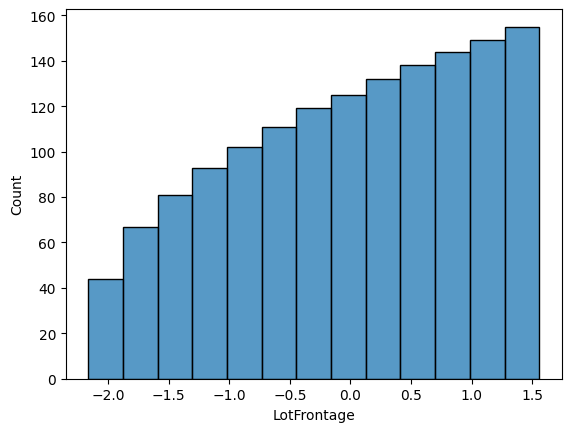

In [179]:
sns.histplot(X_preprocessed_df['LotFrontage'])

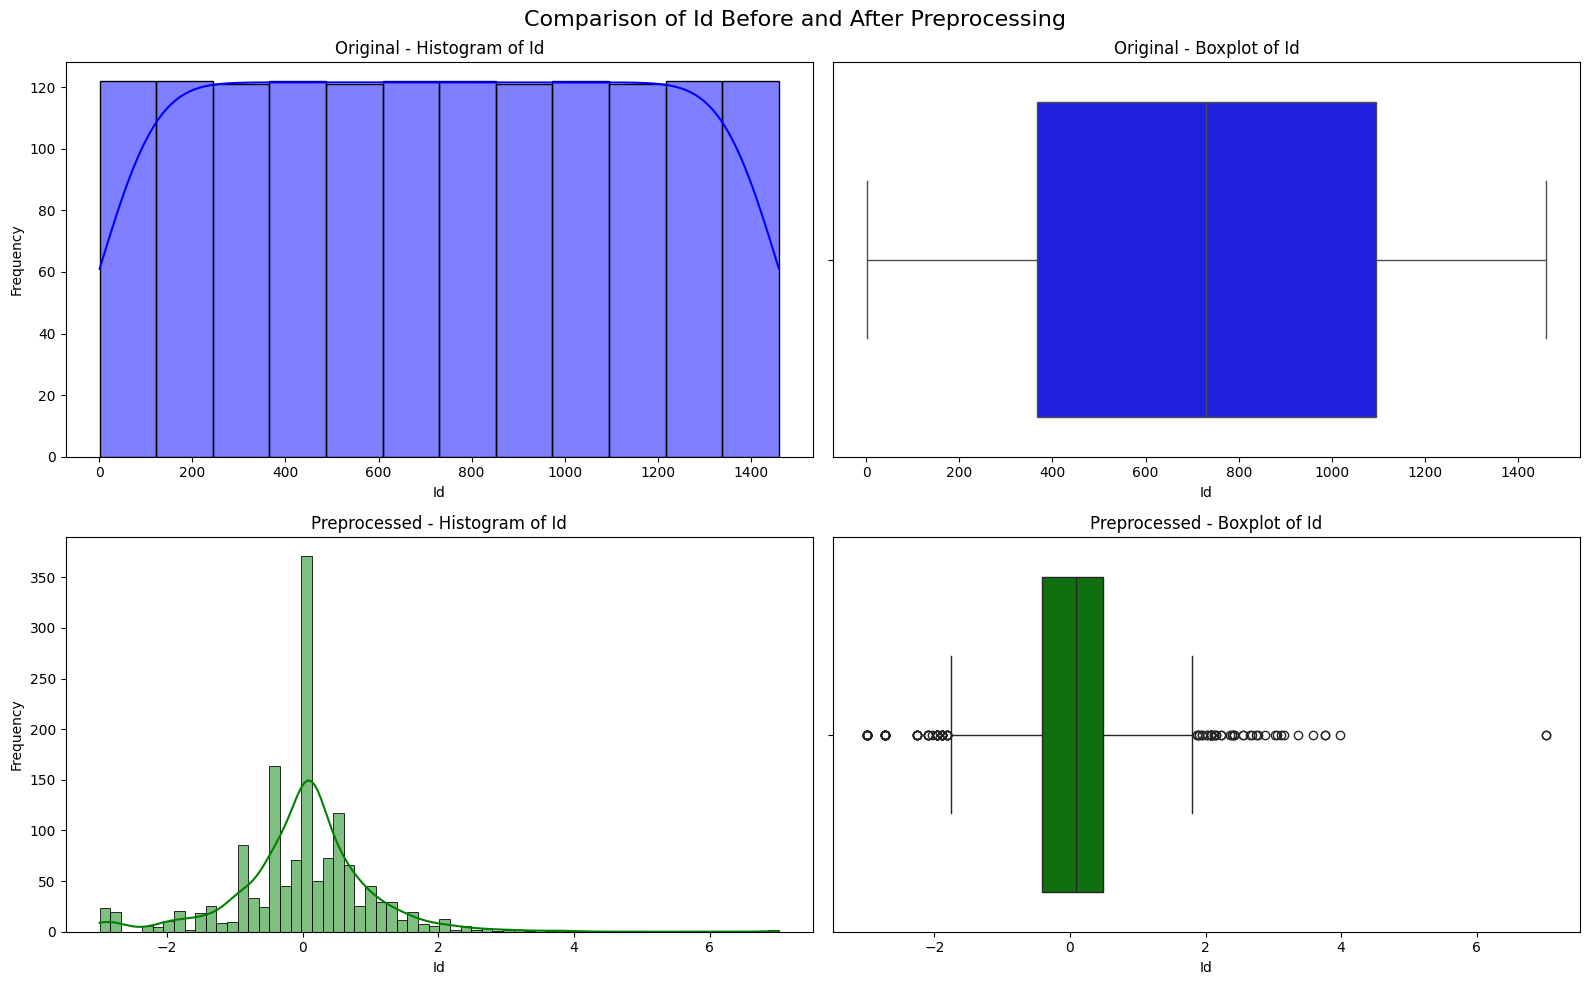

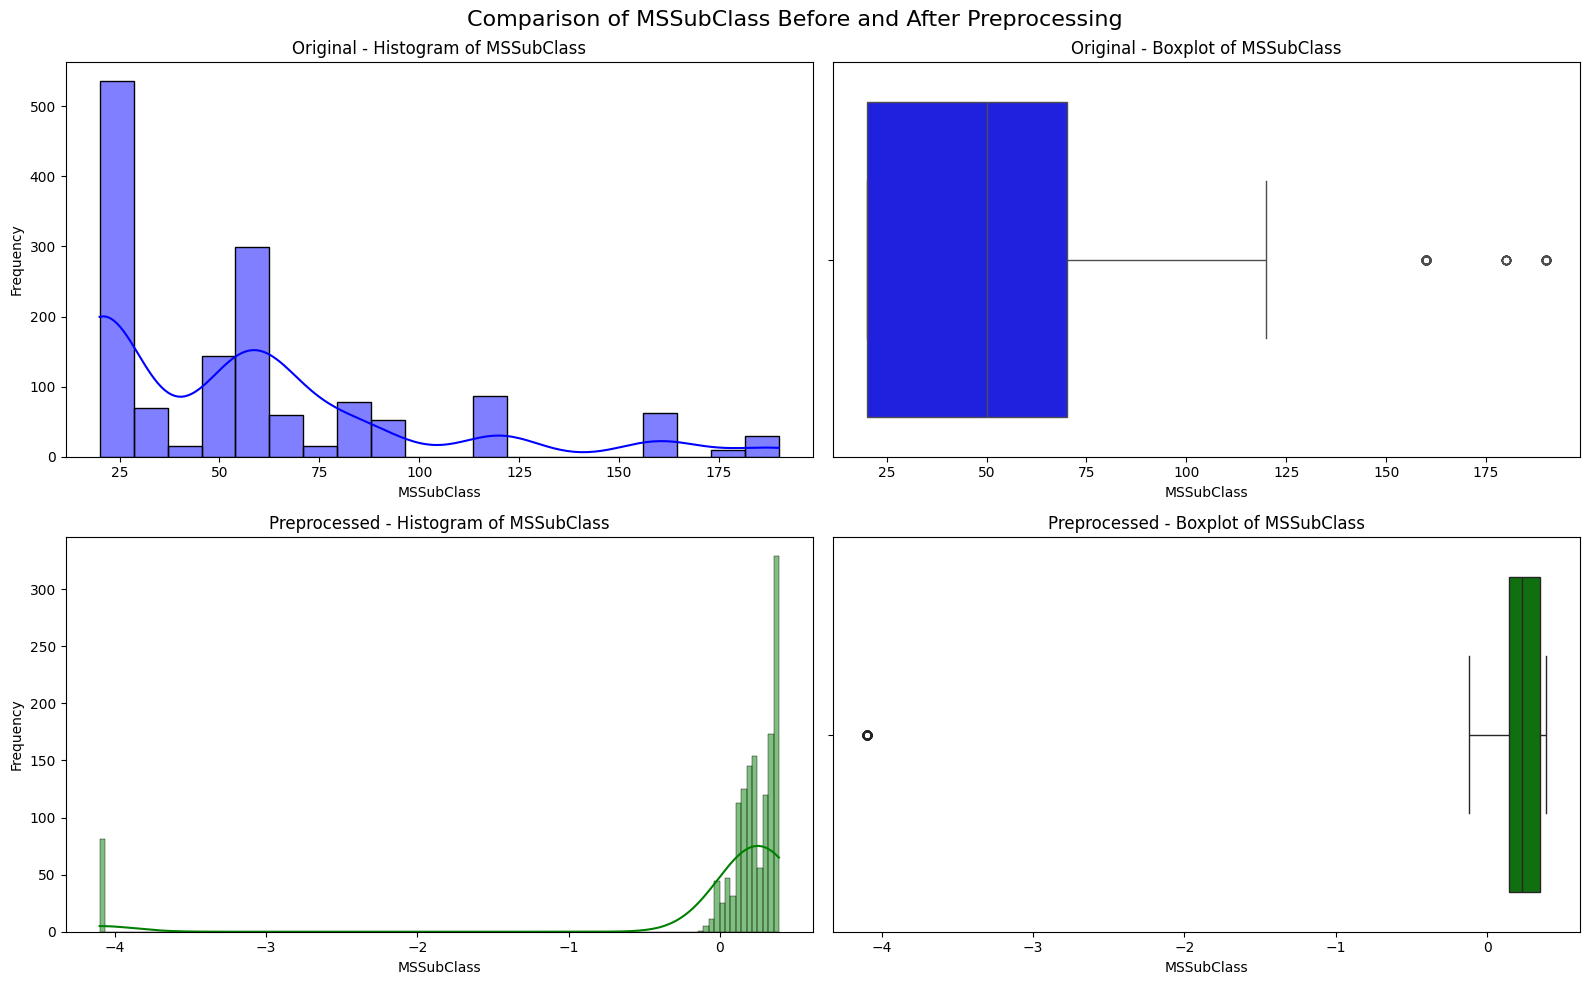

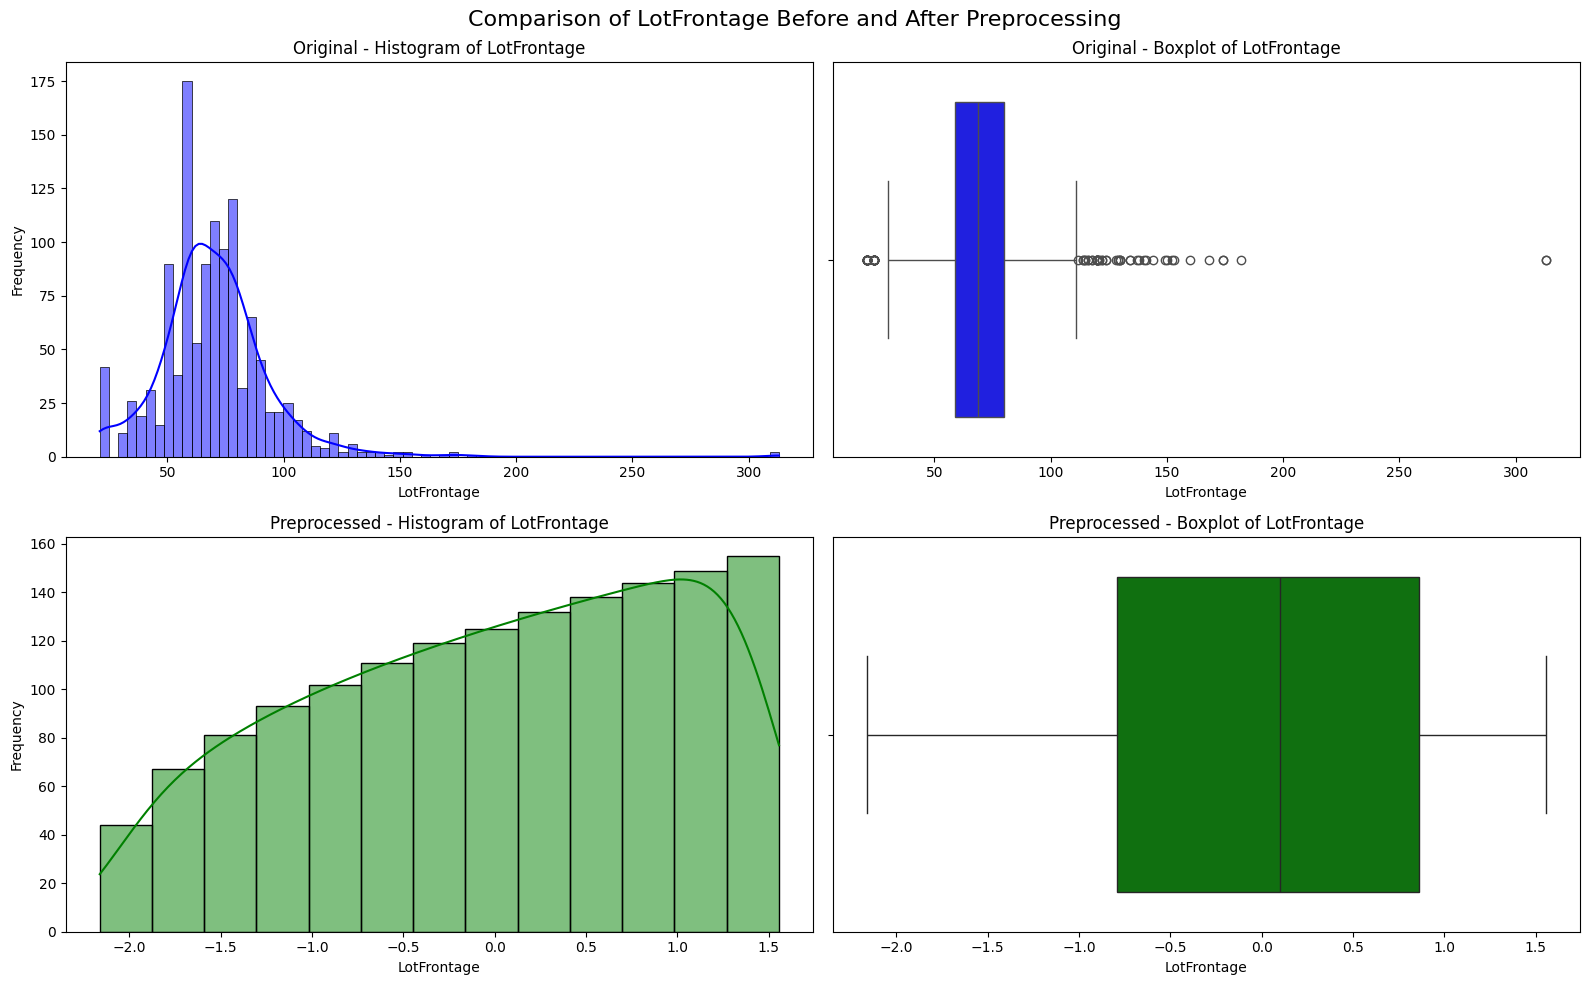

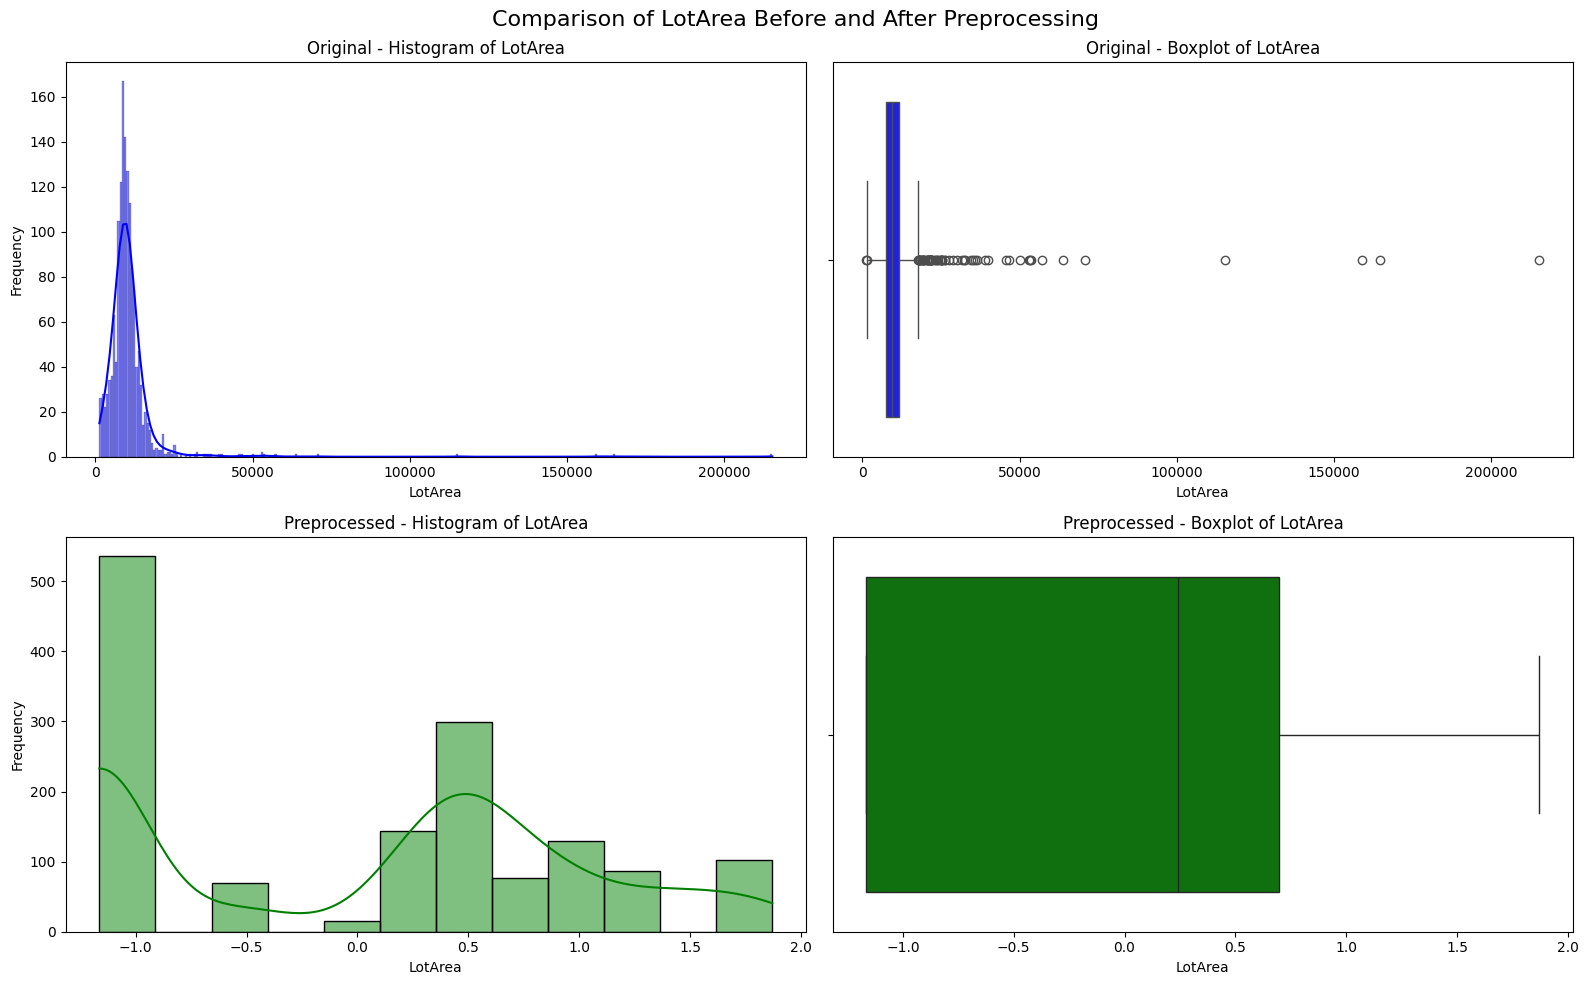

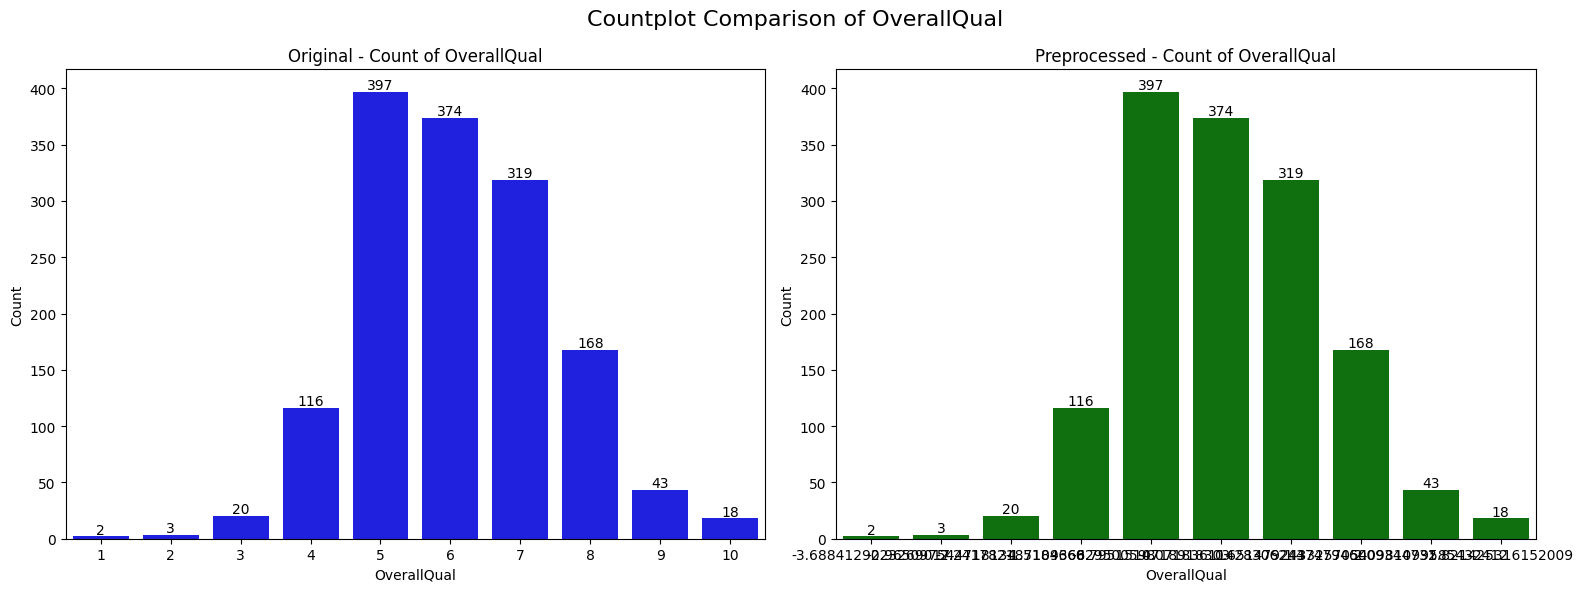

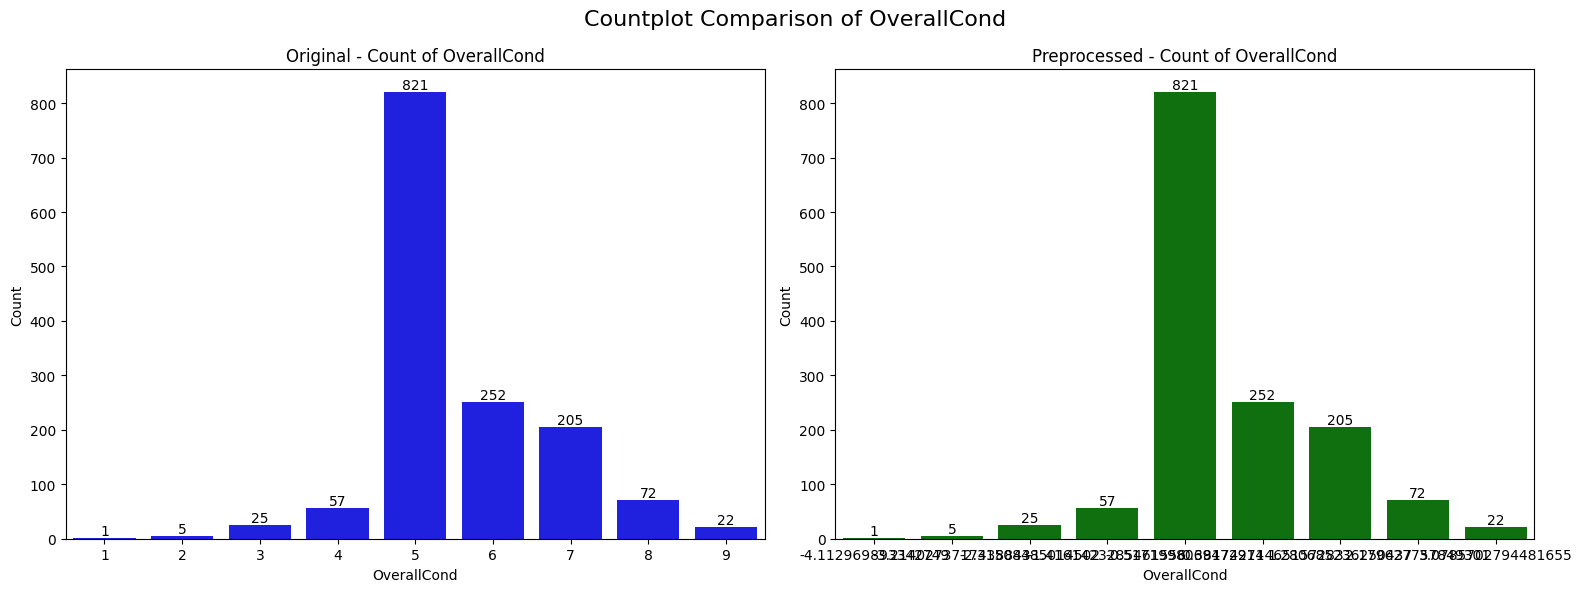

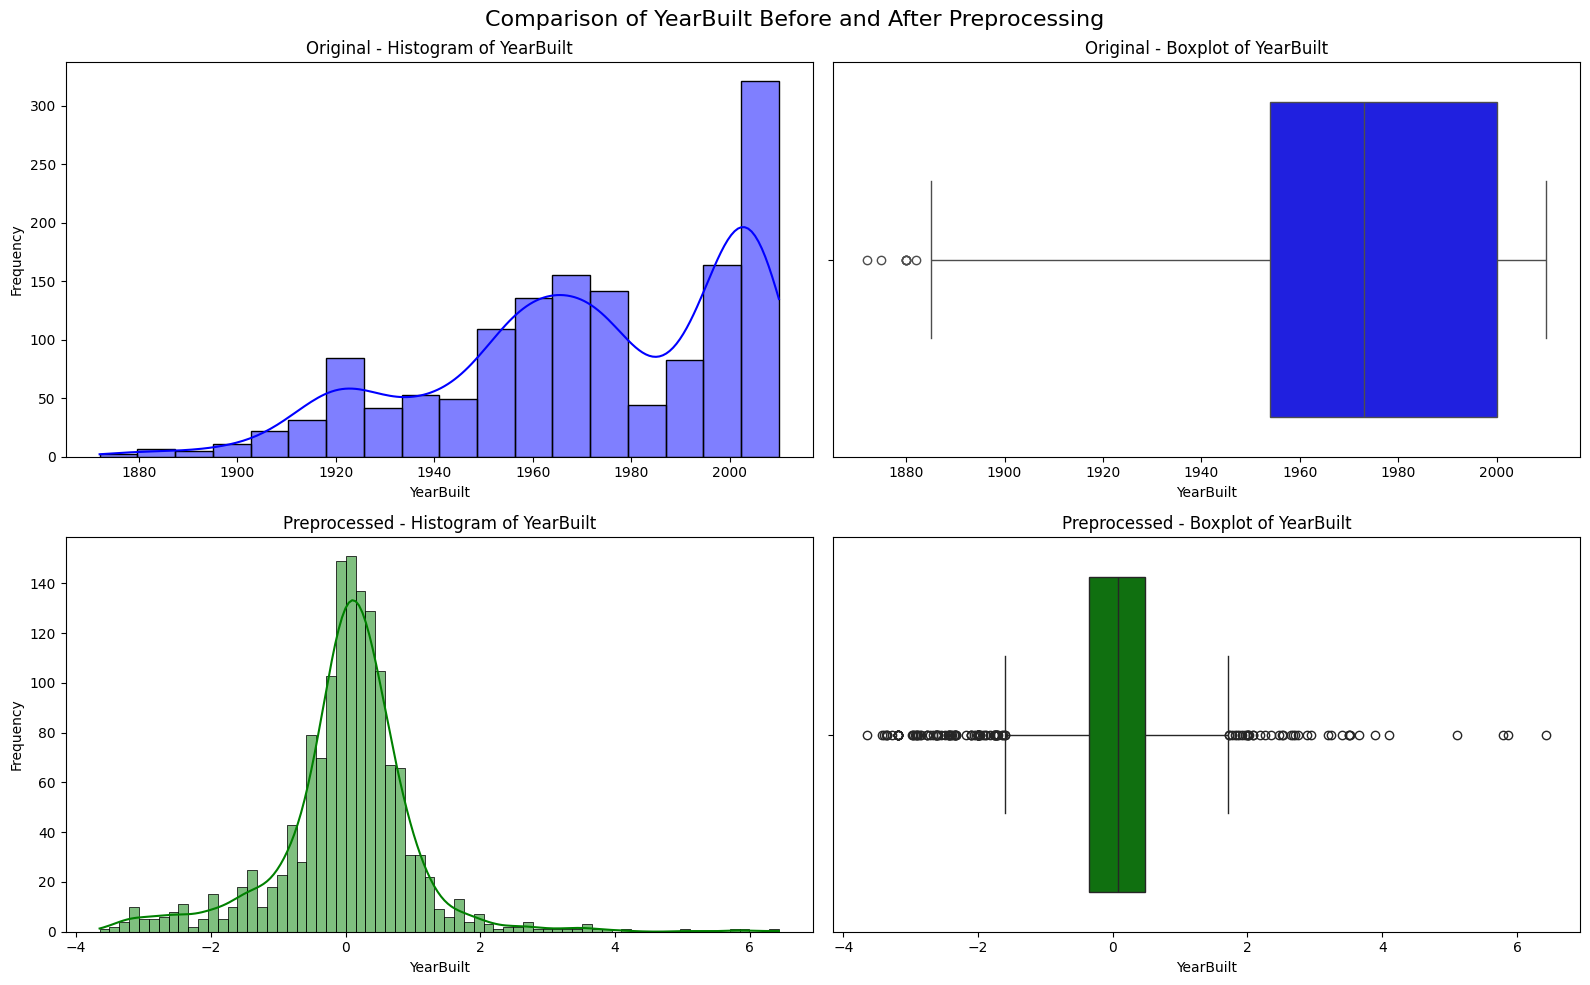

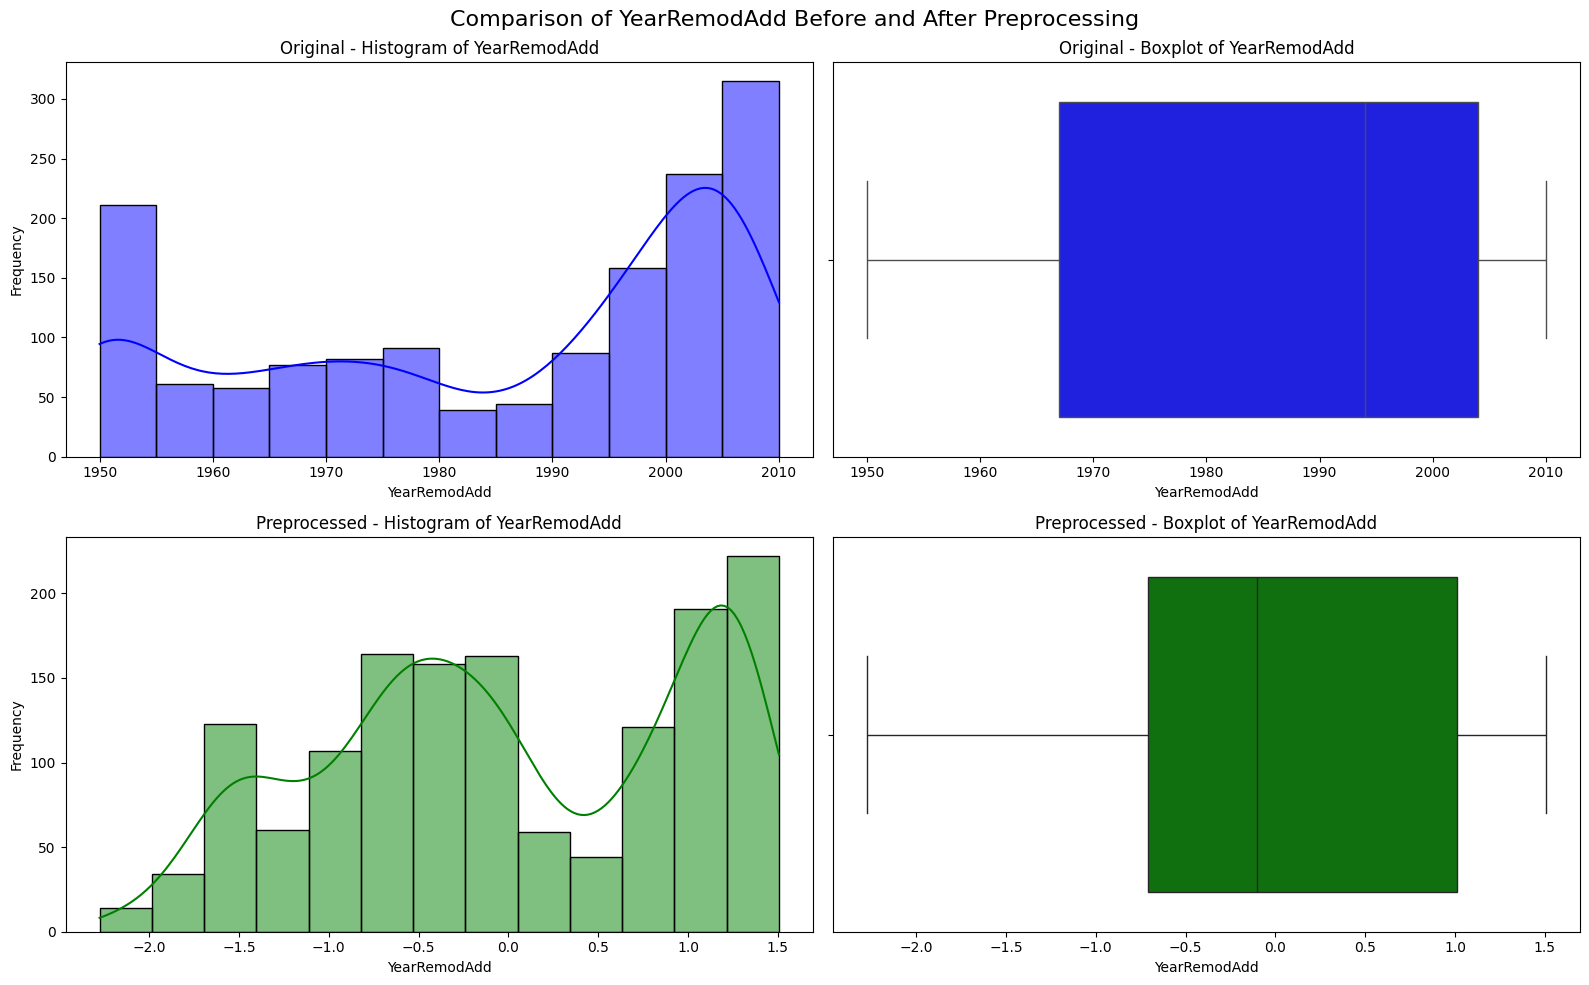

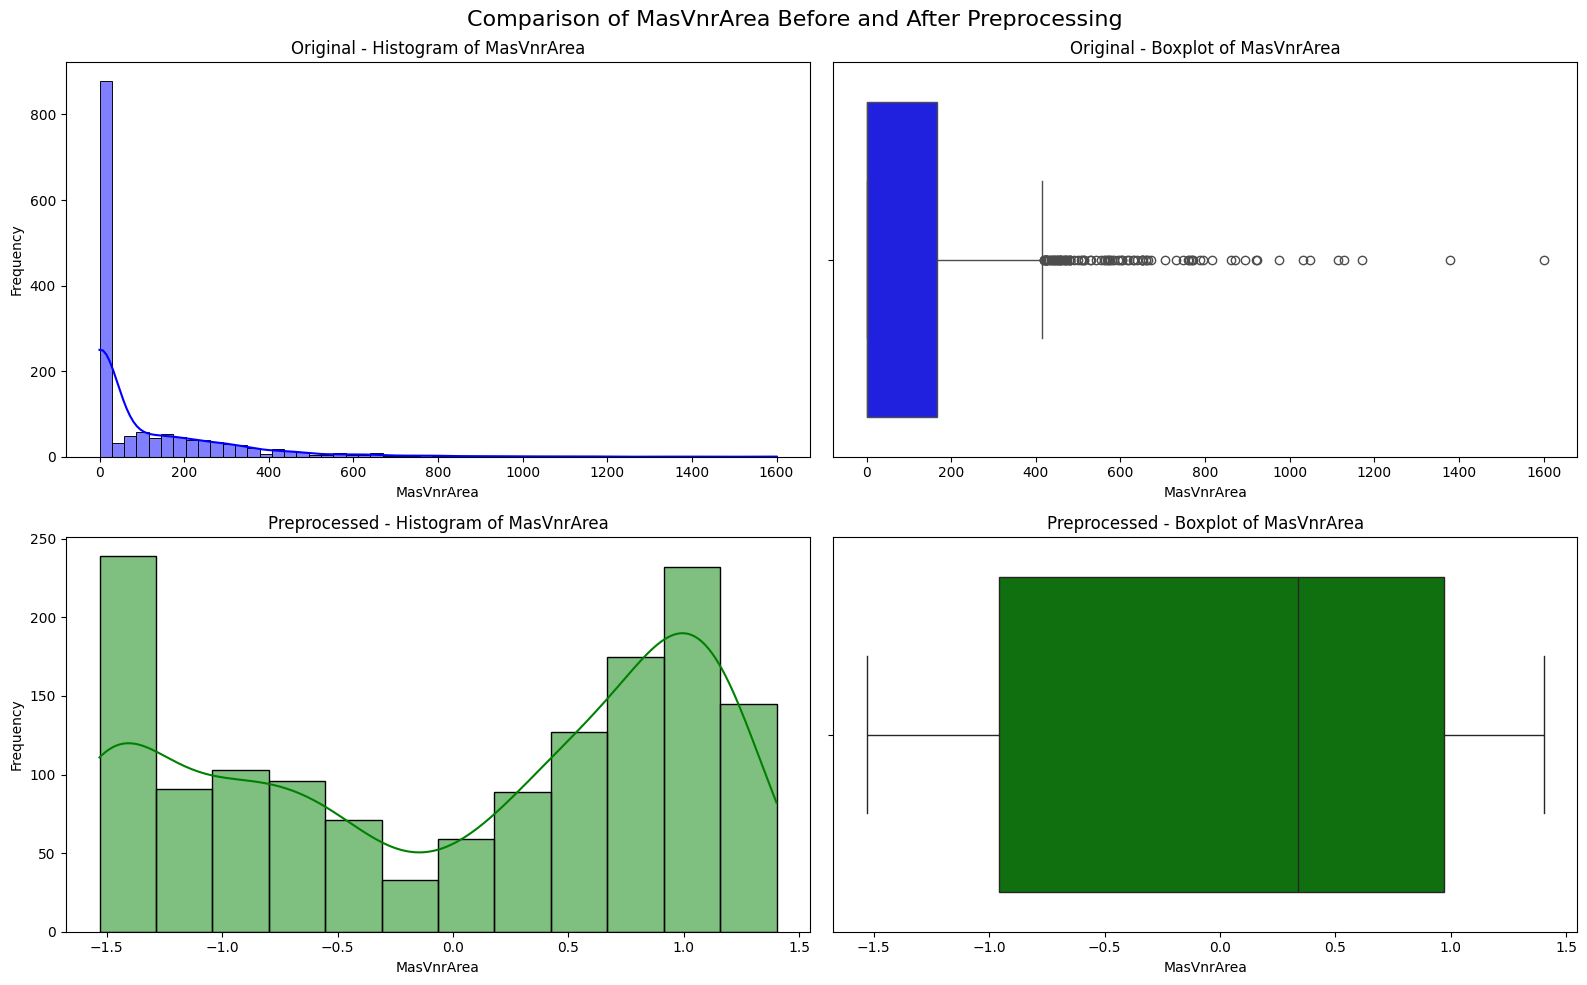

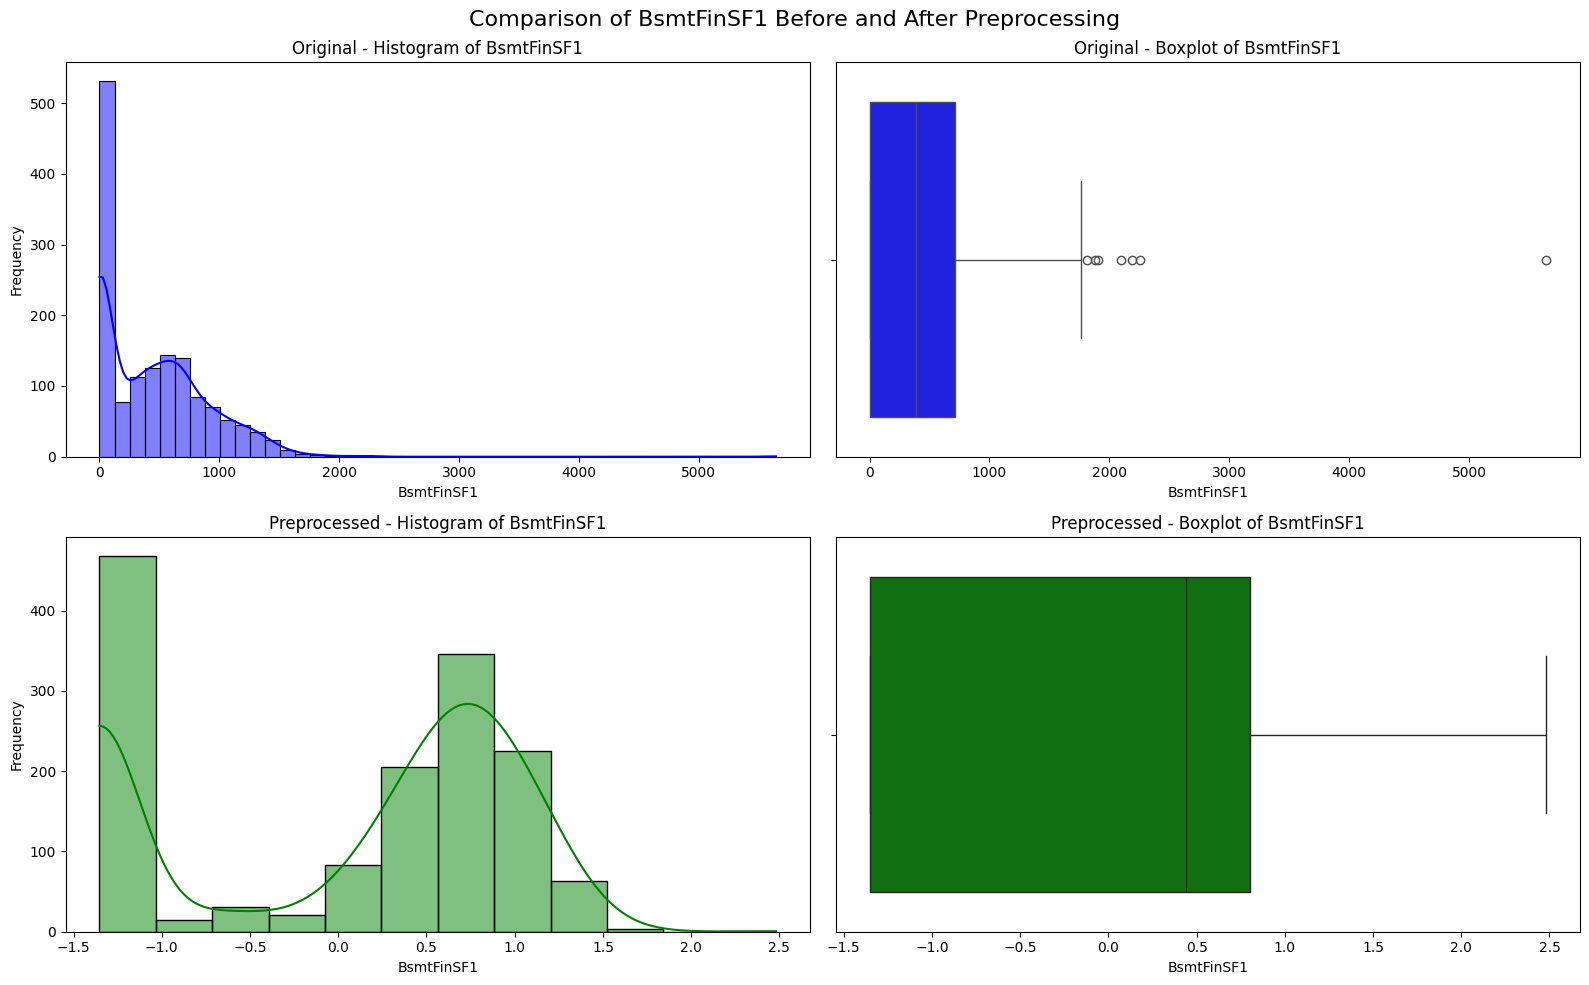

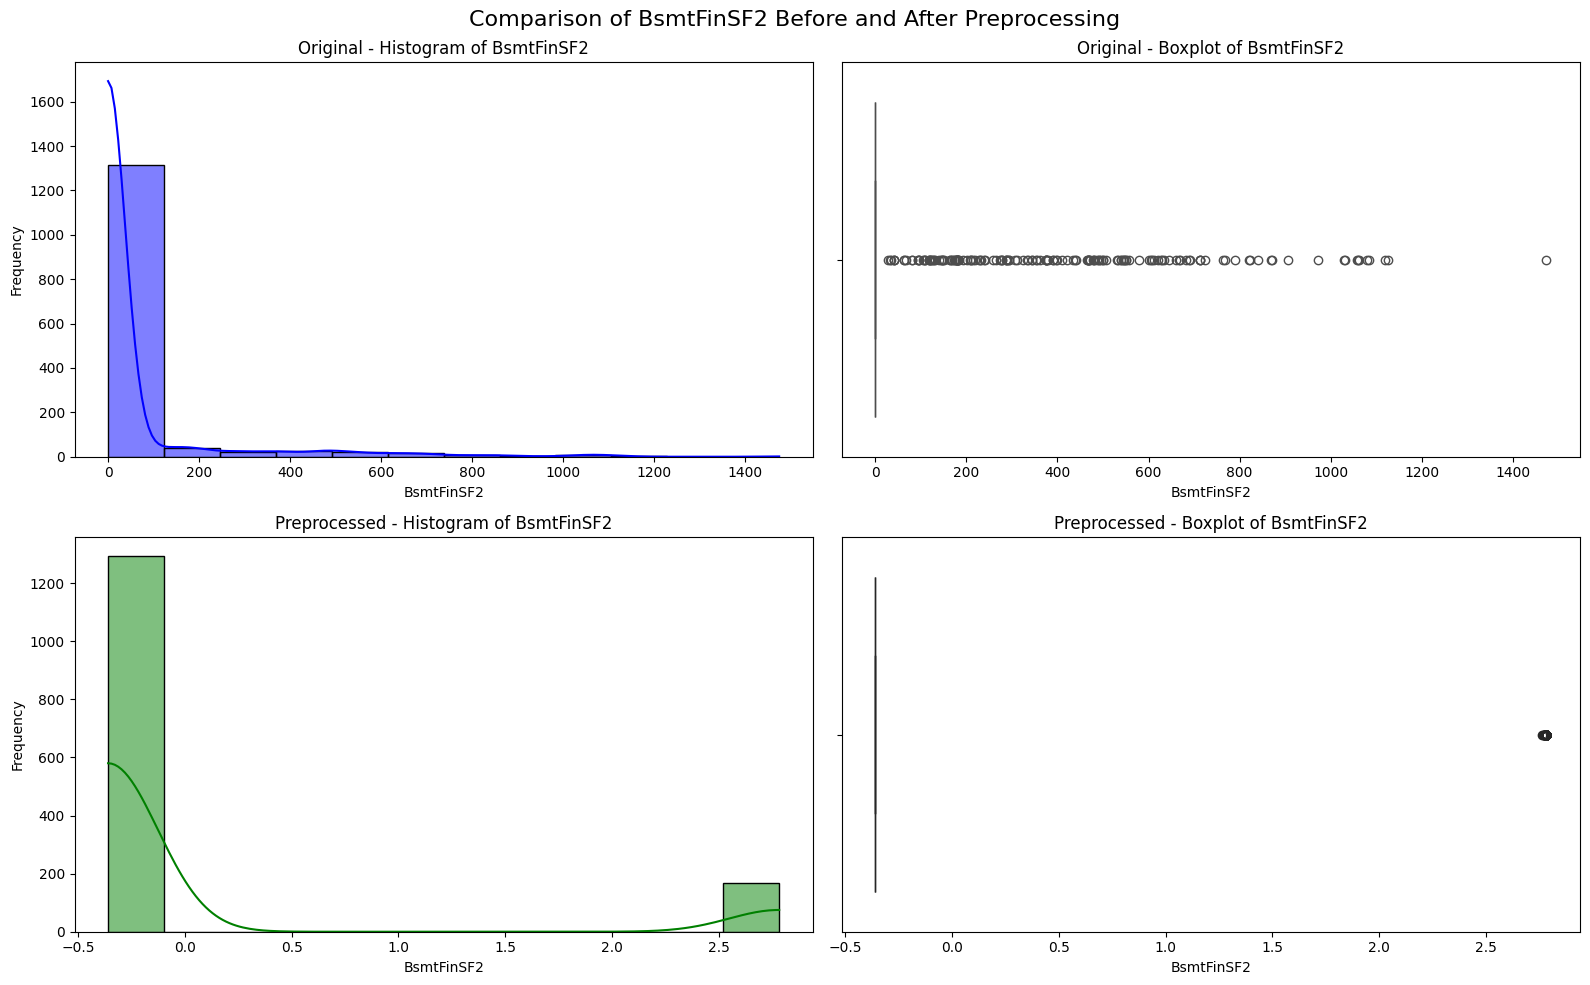

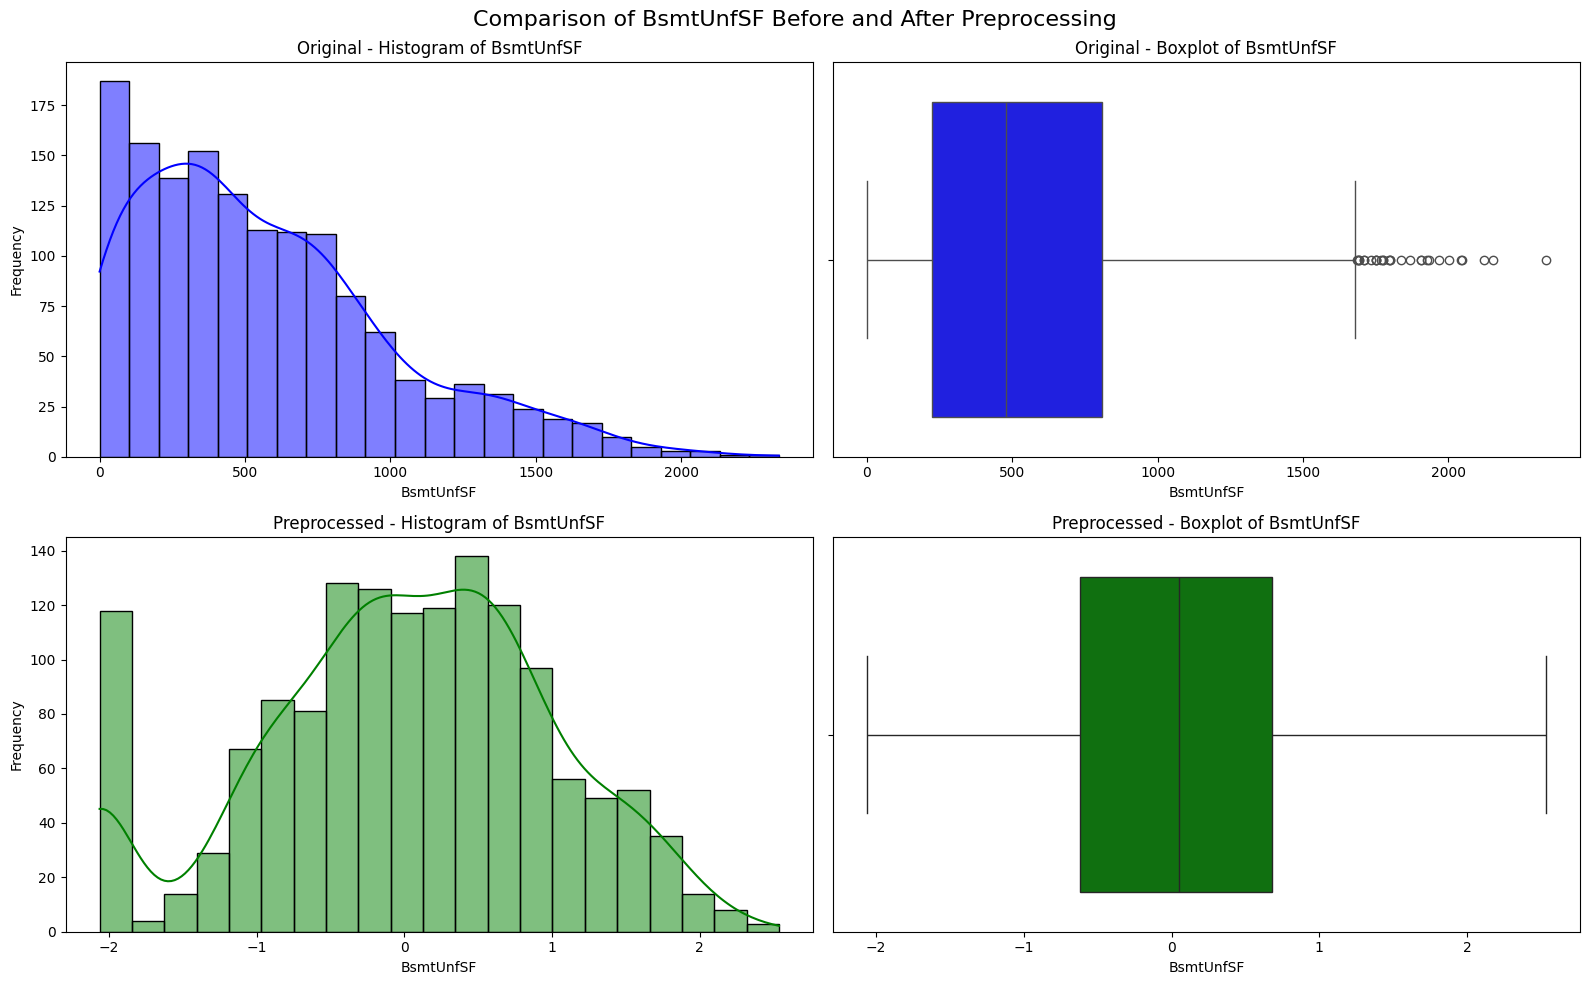

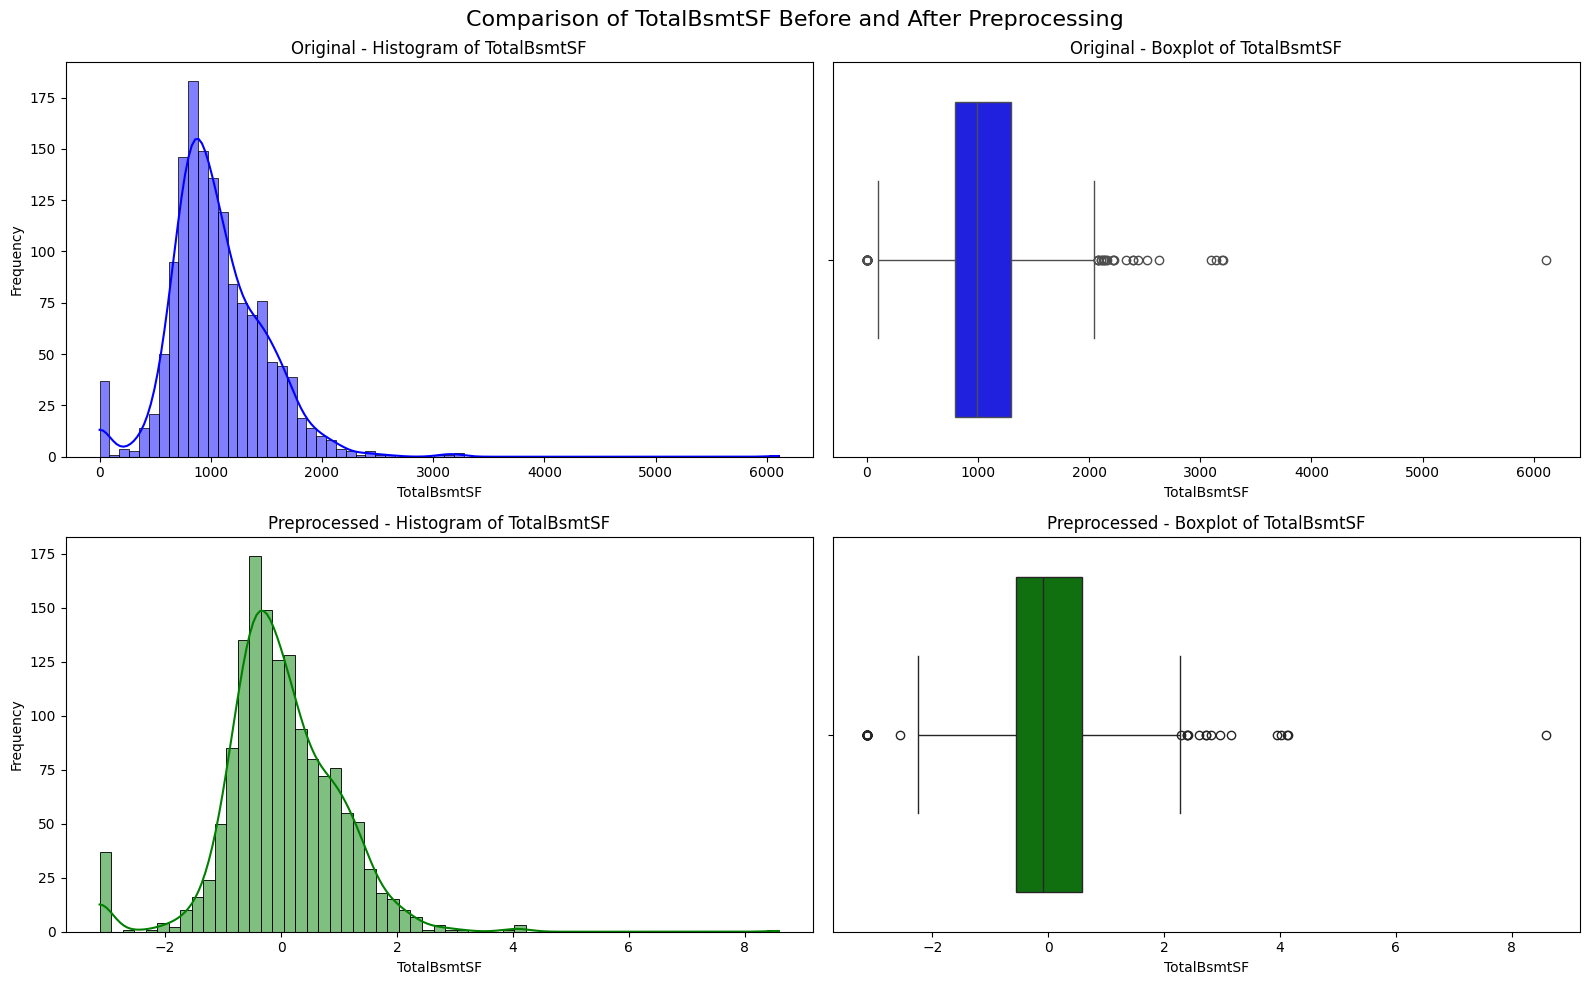

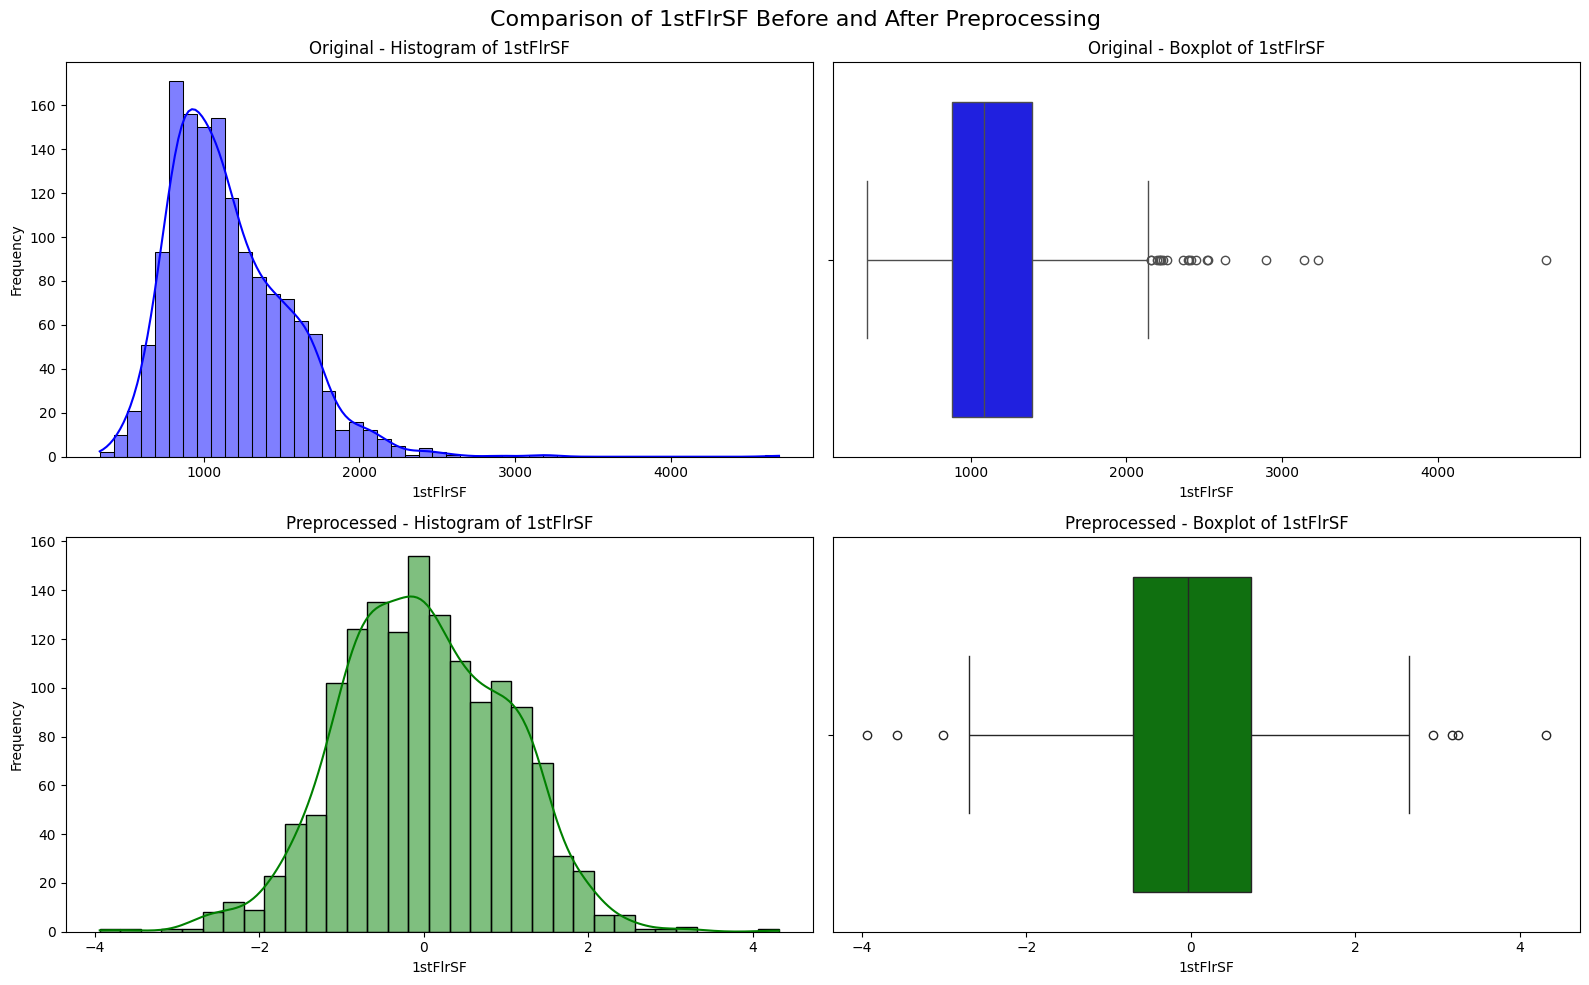

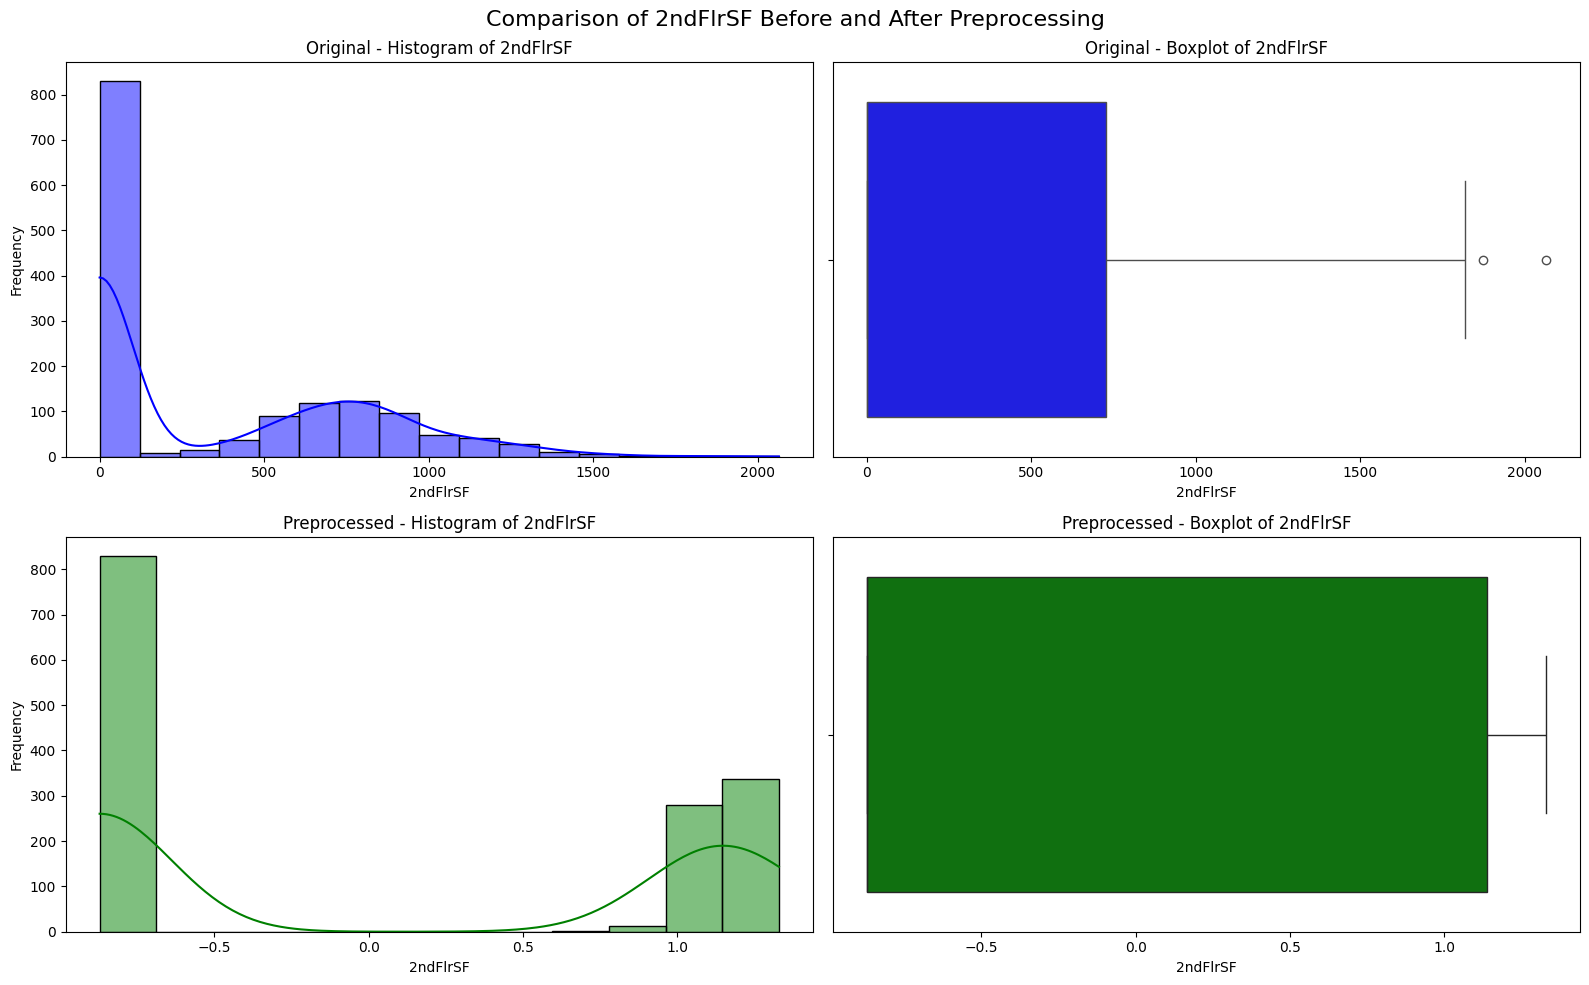

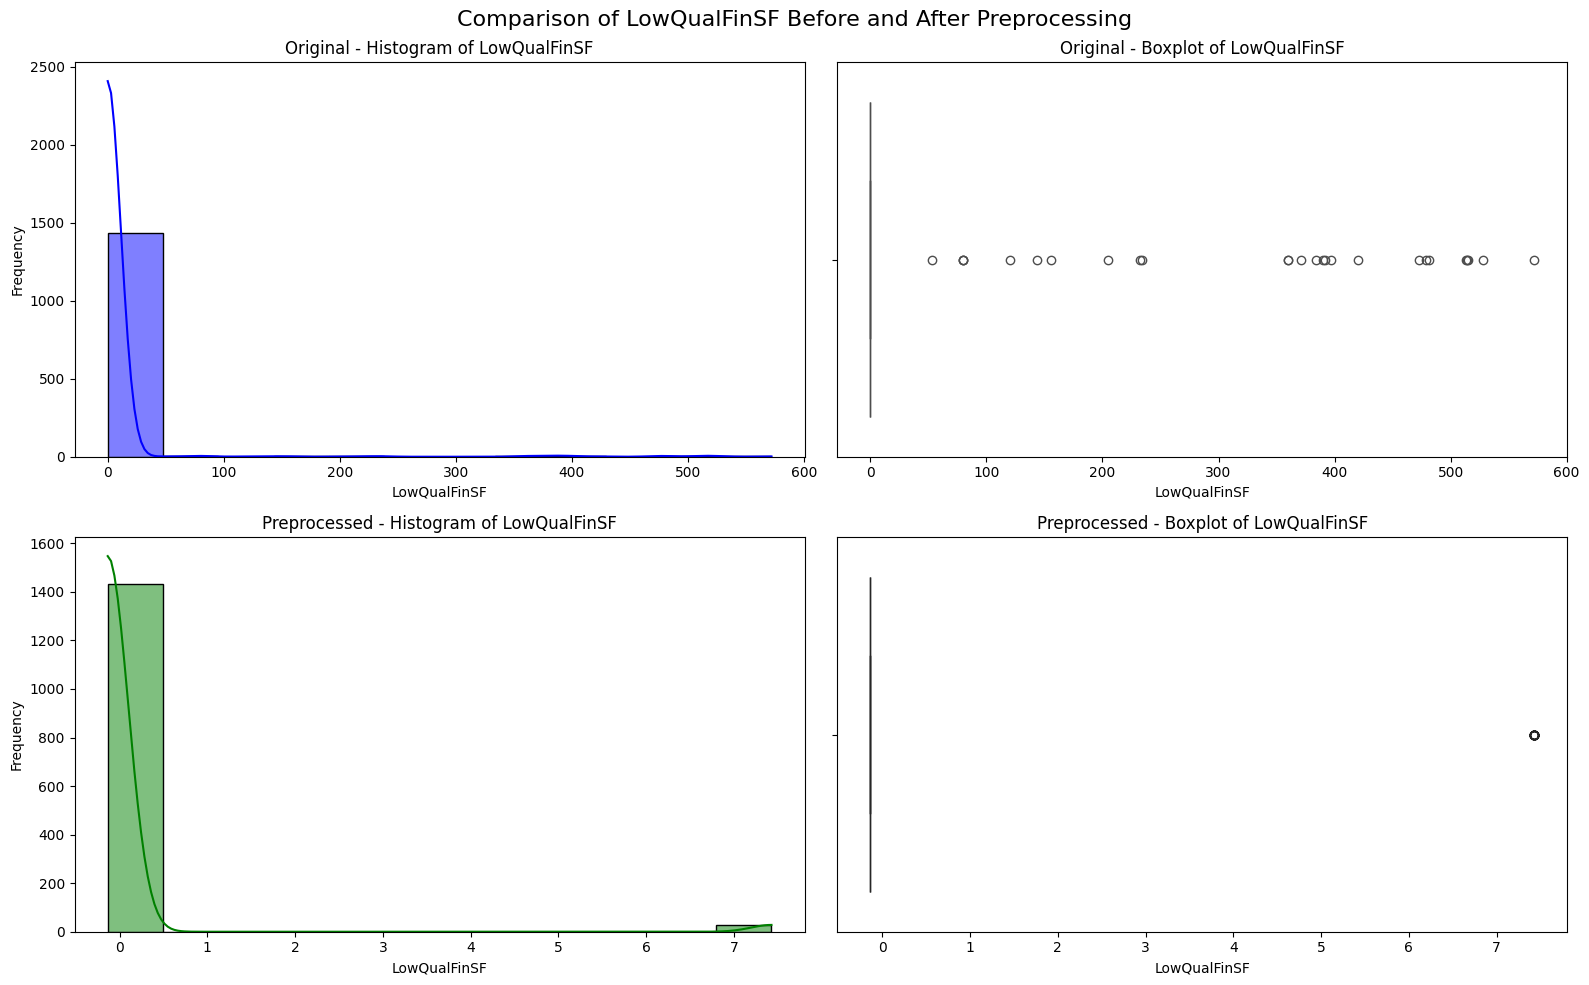

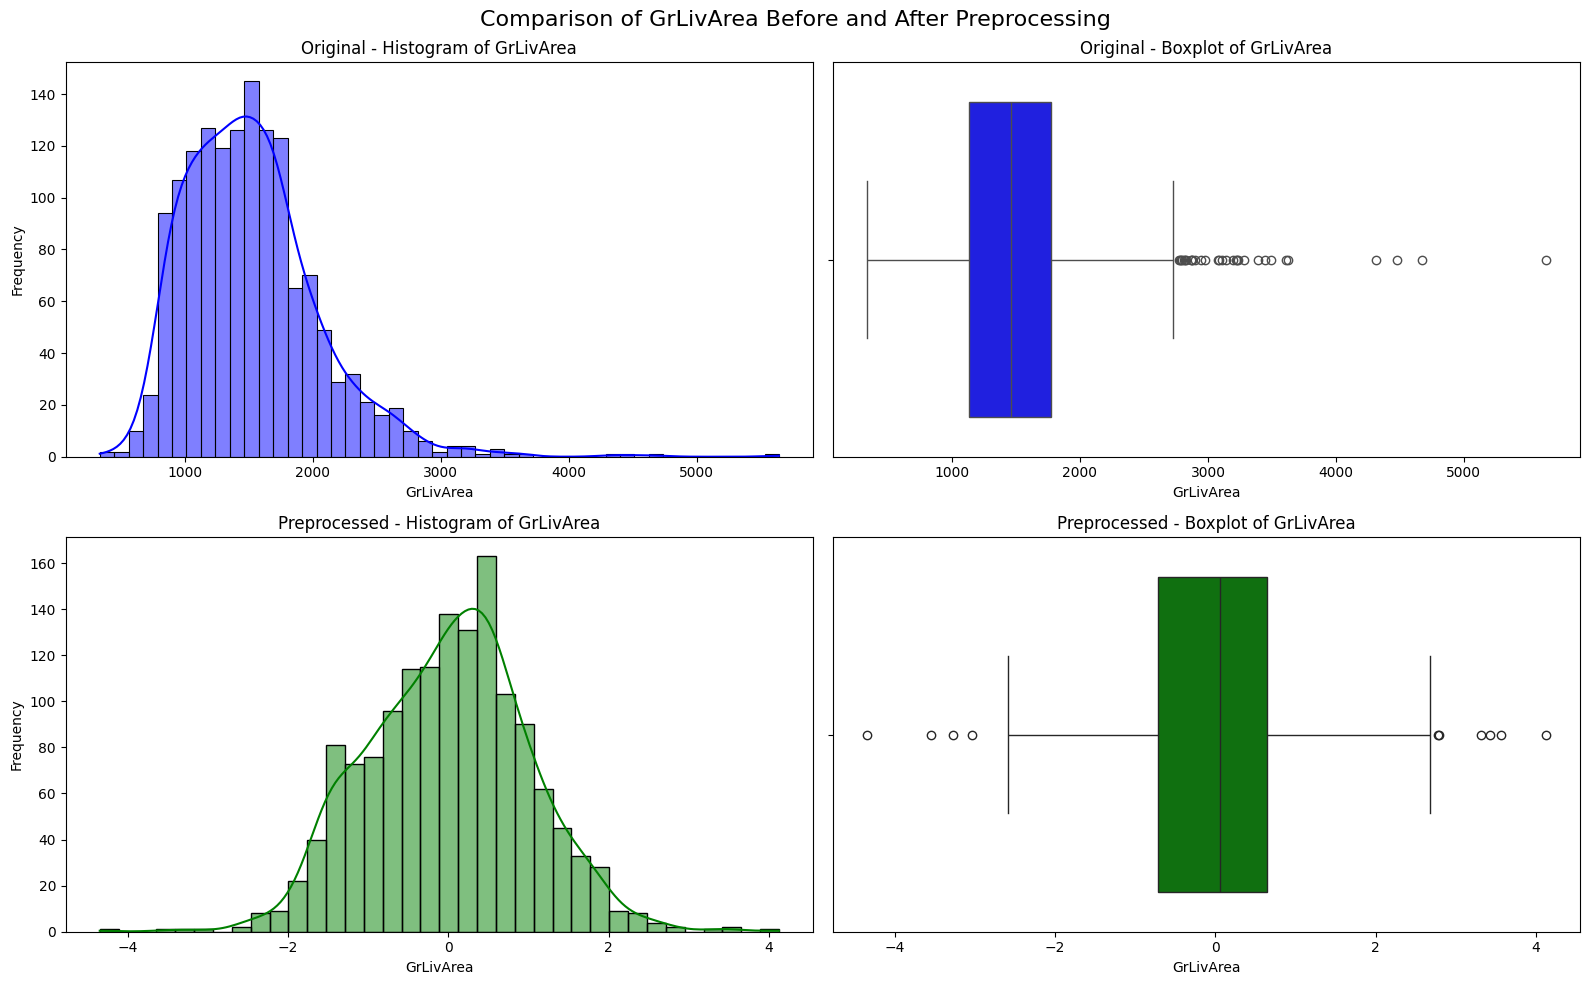

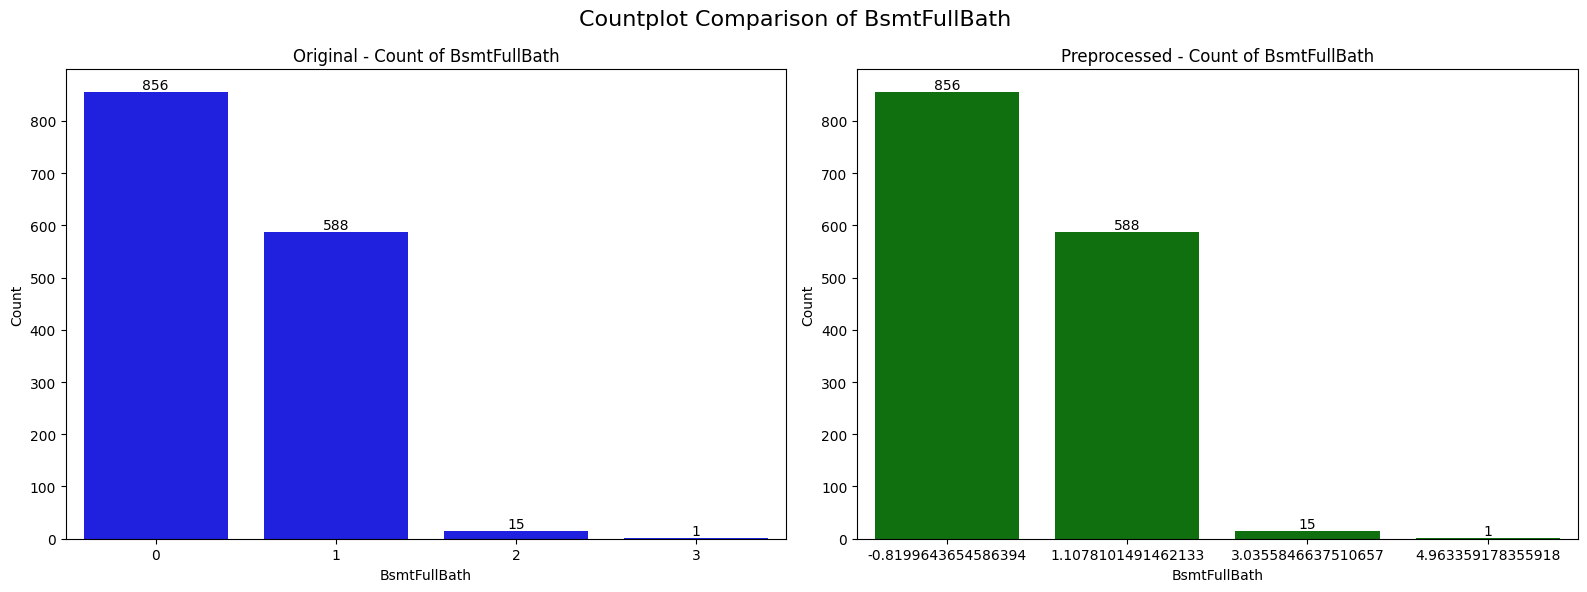

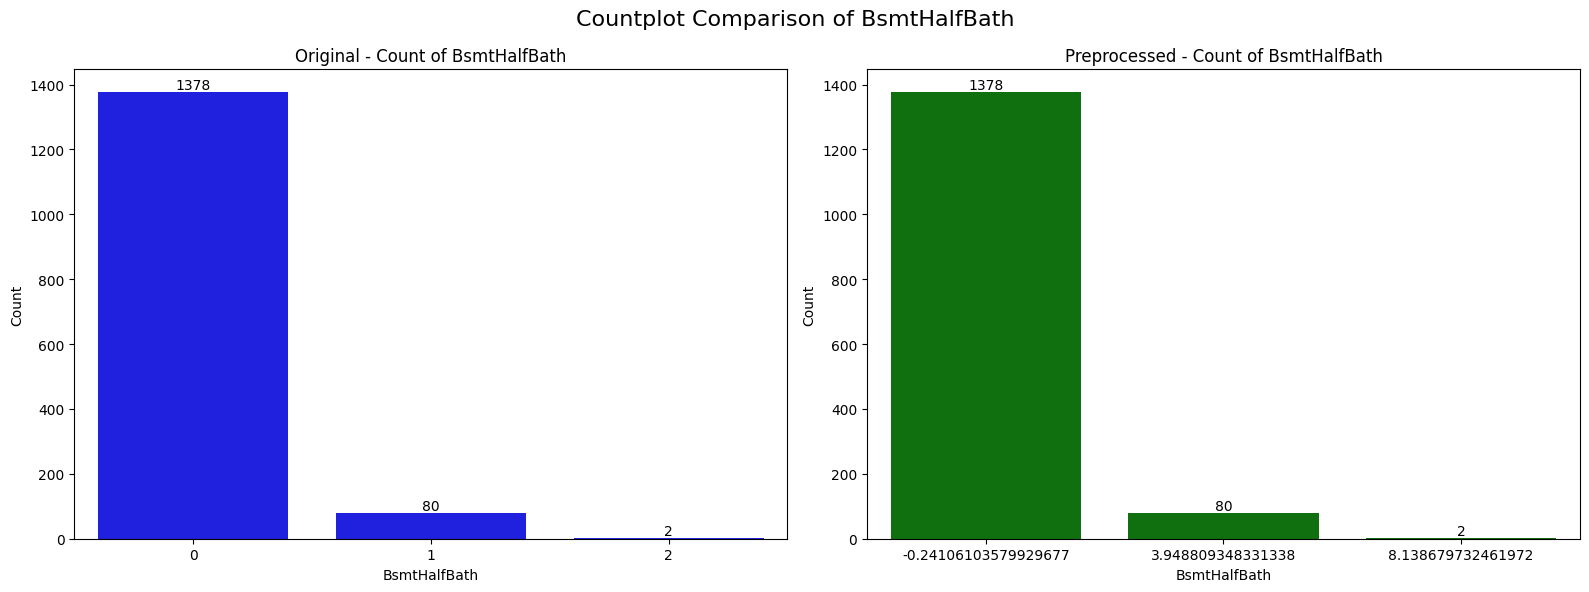

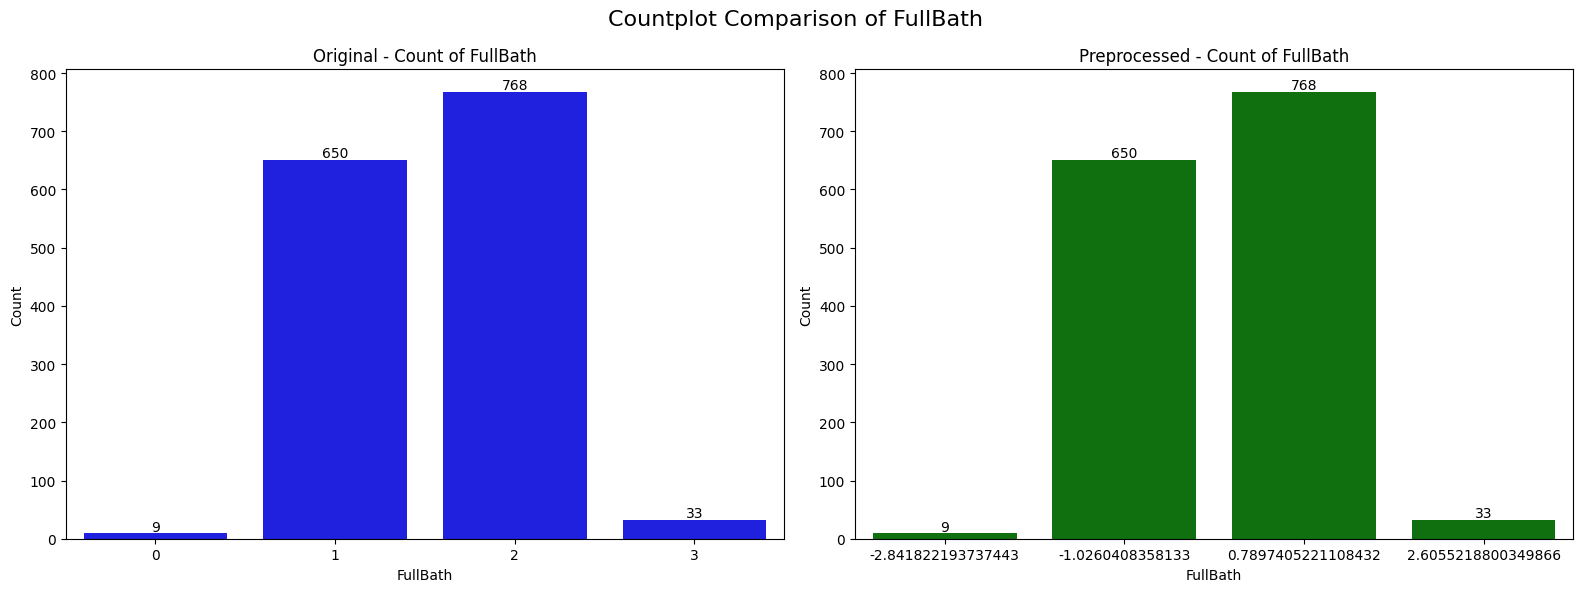

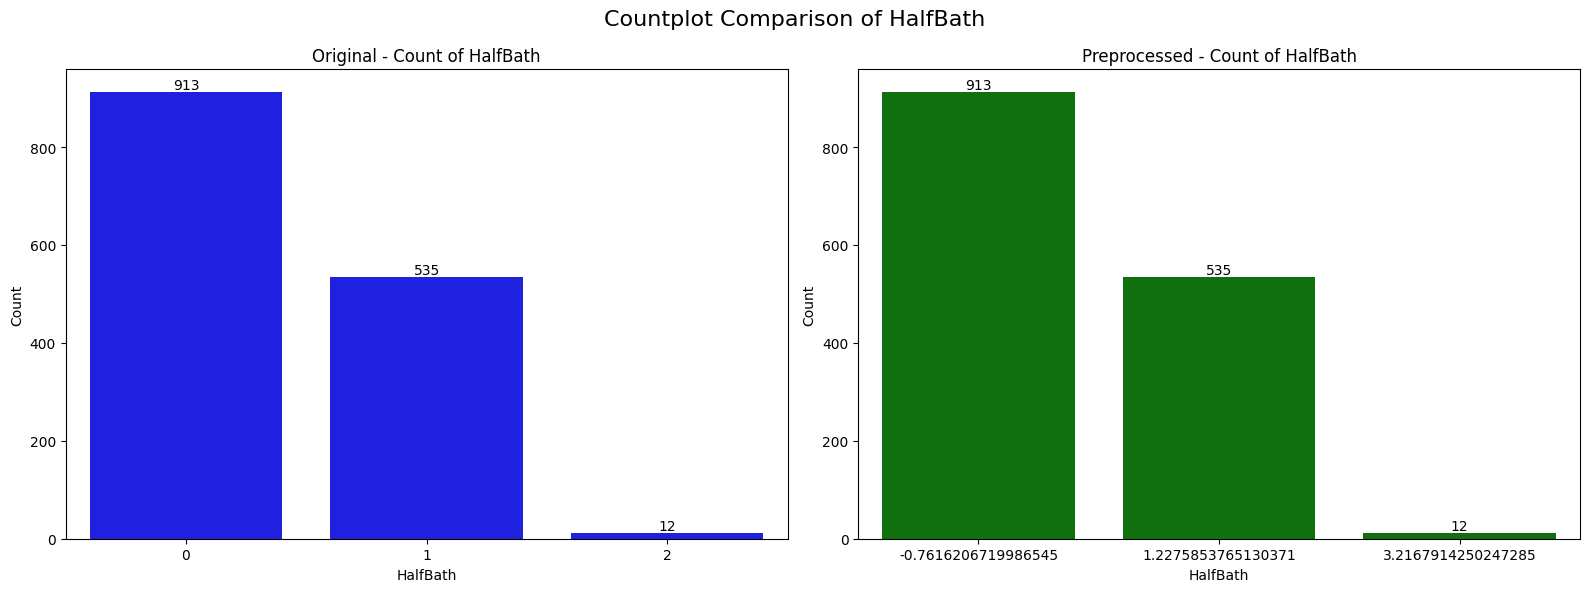

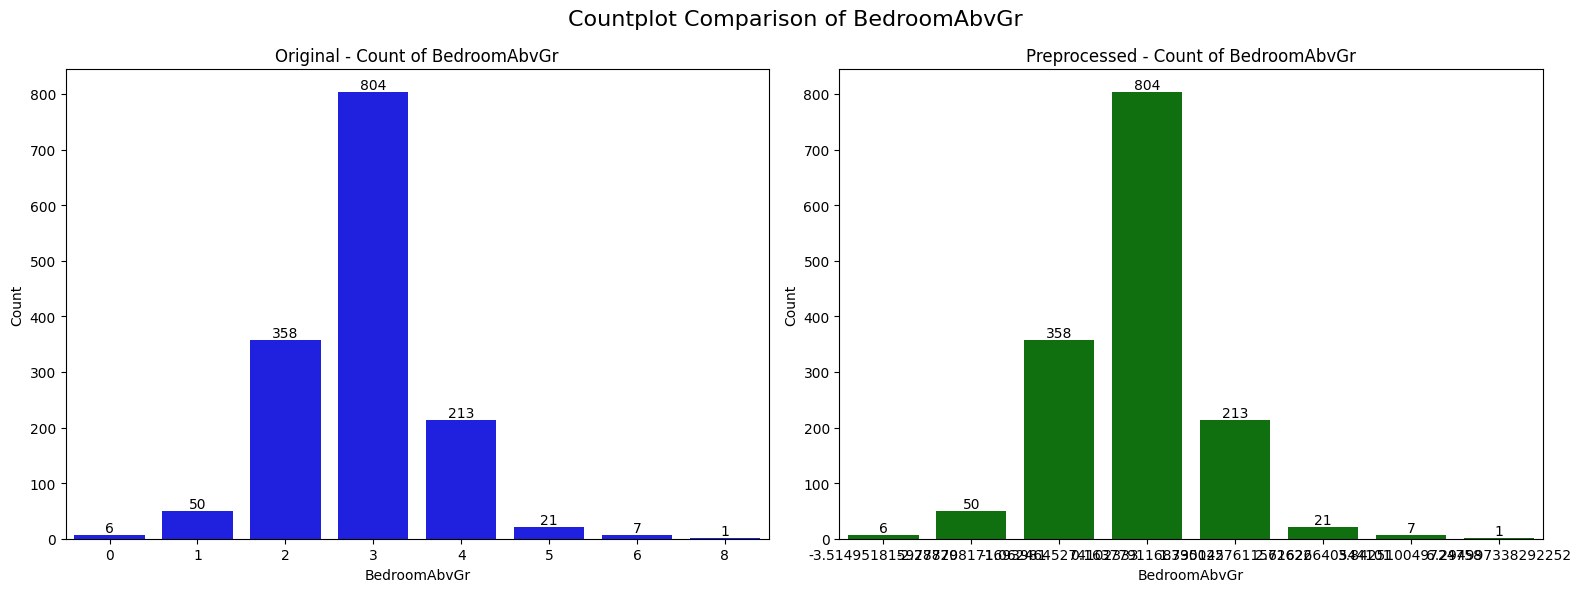

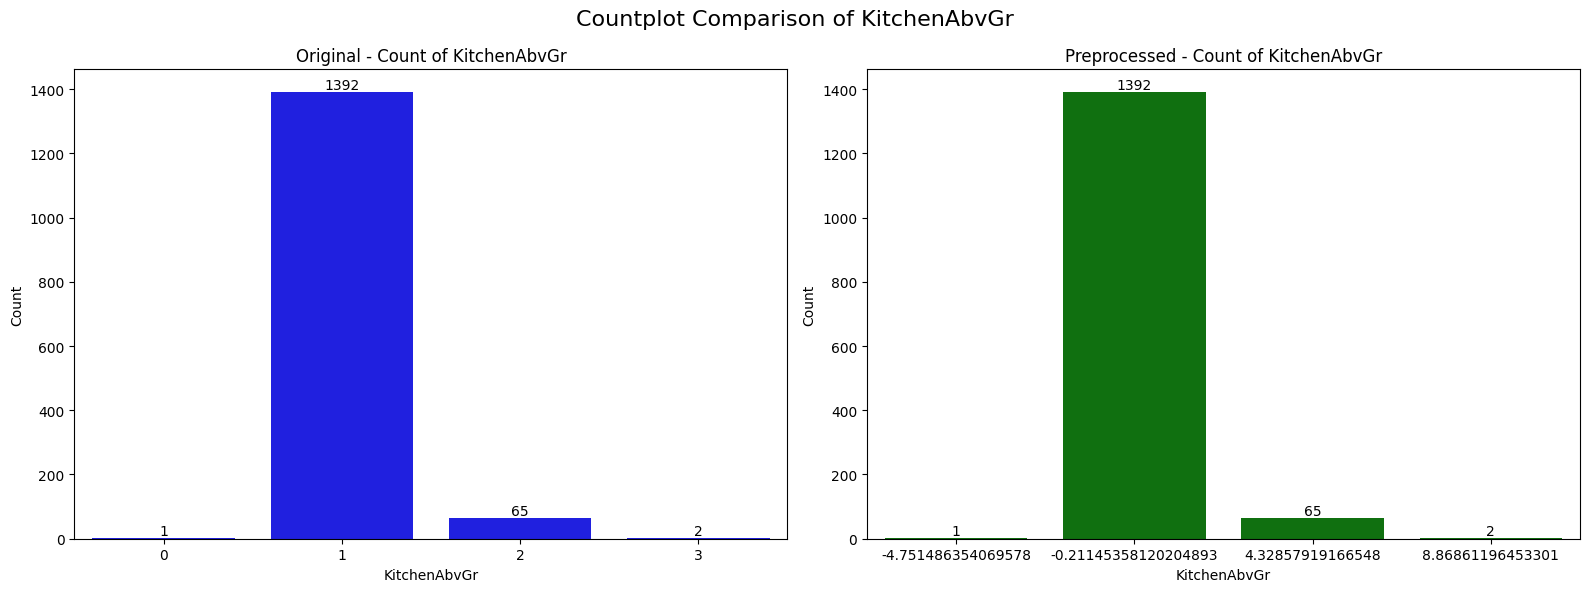

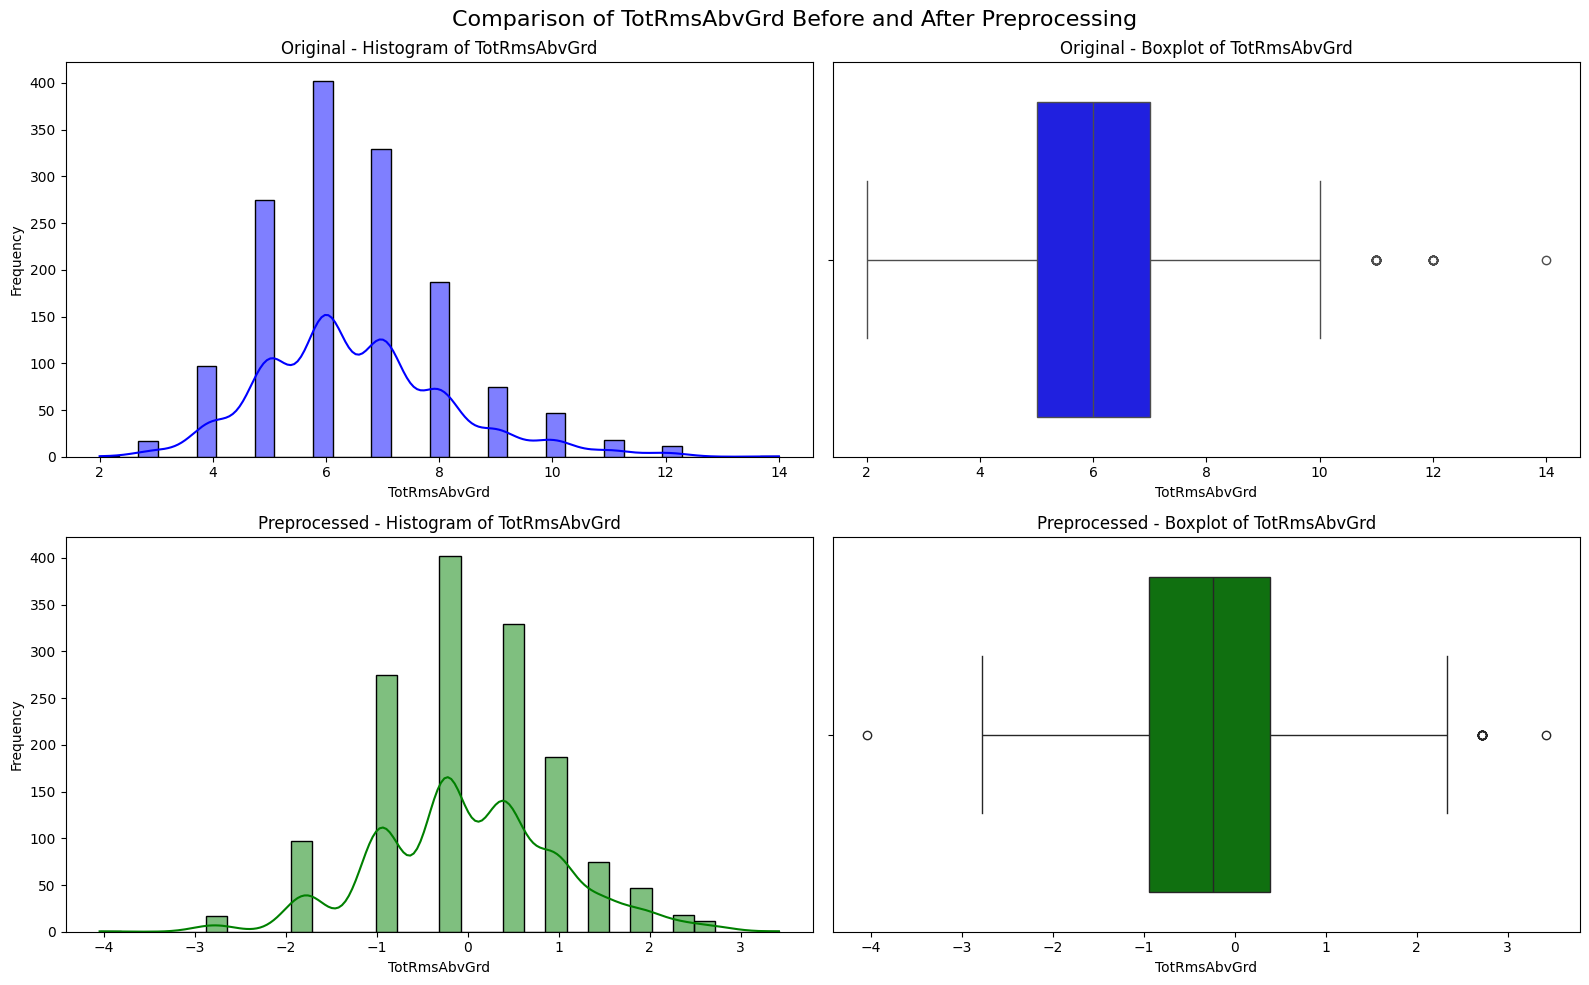

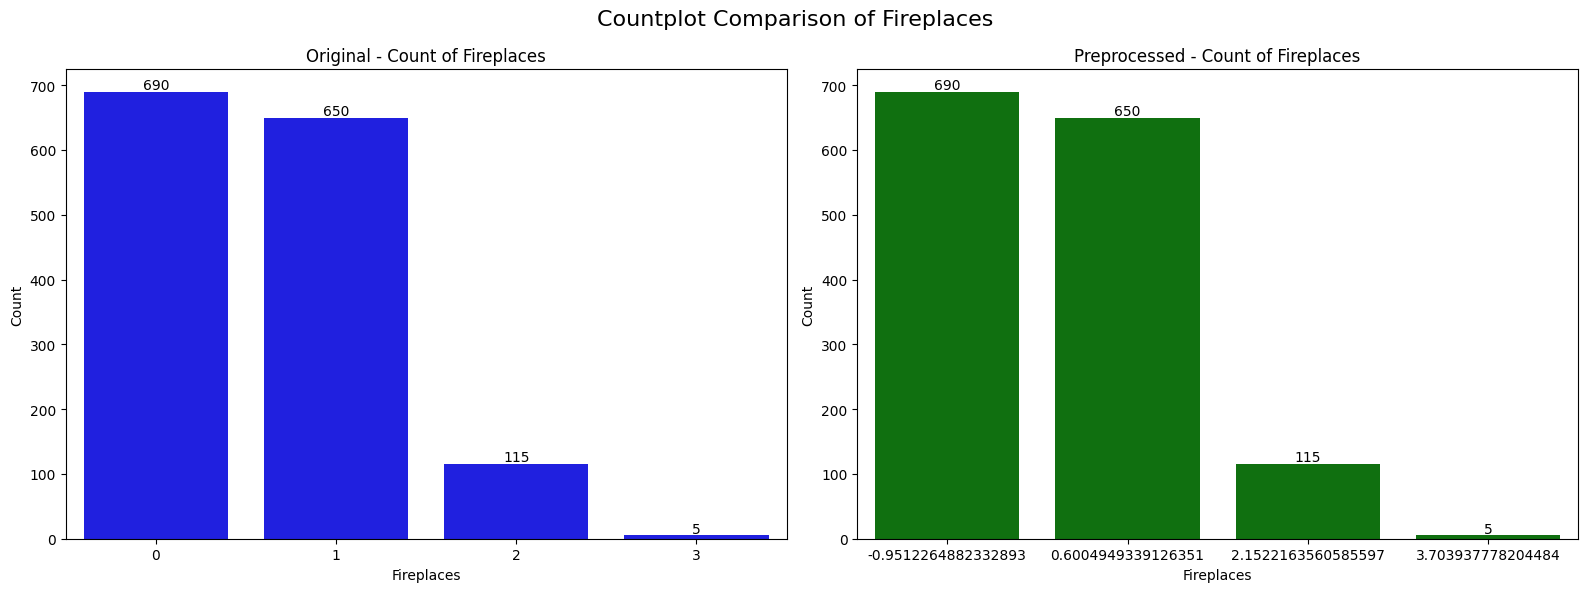

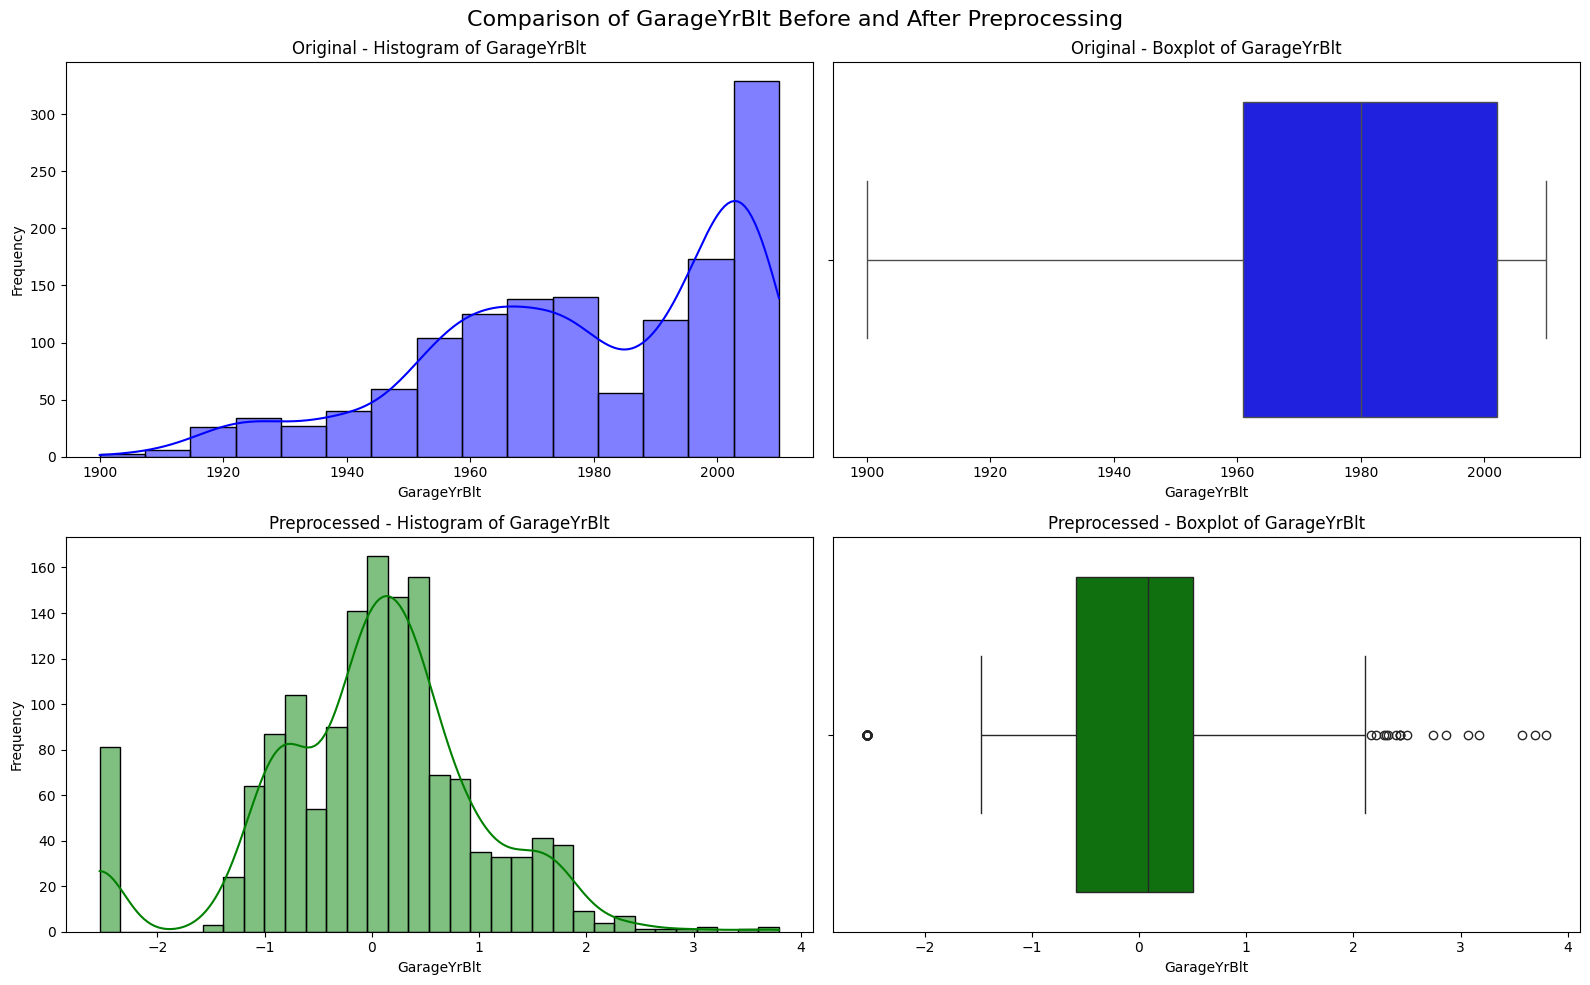

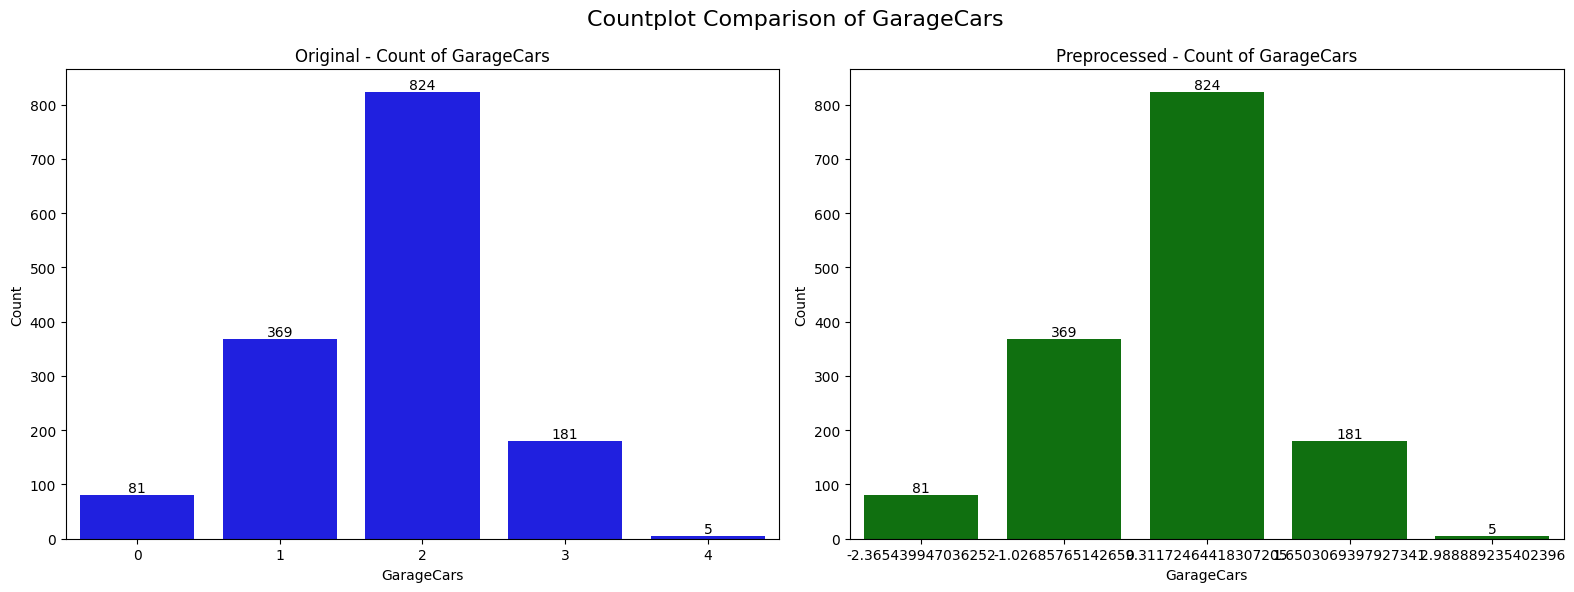

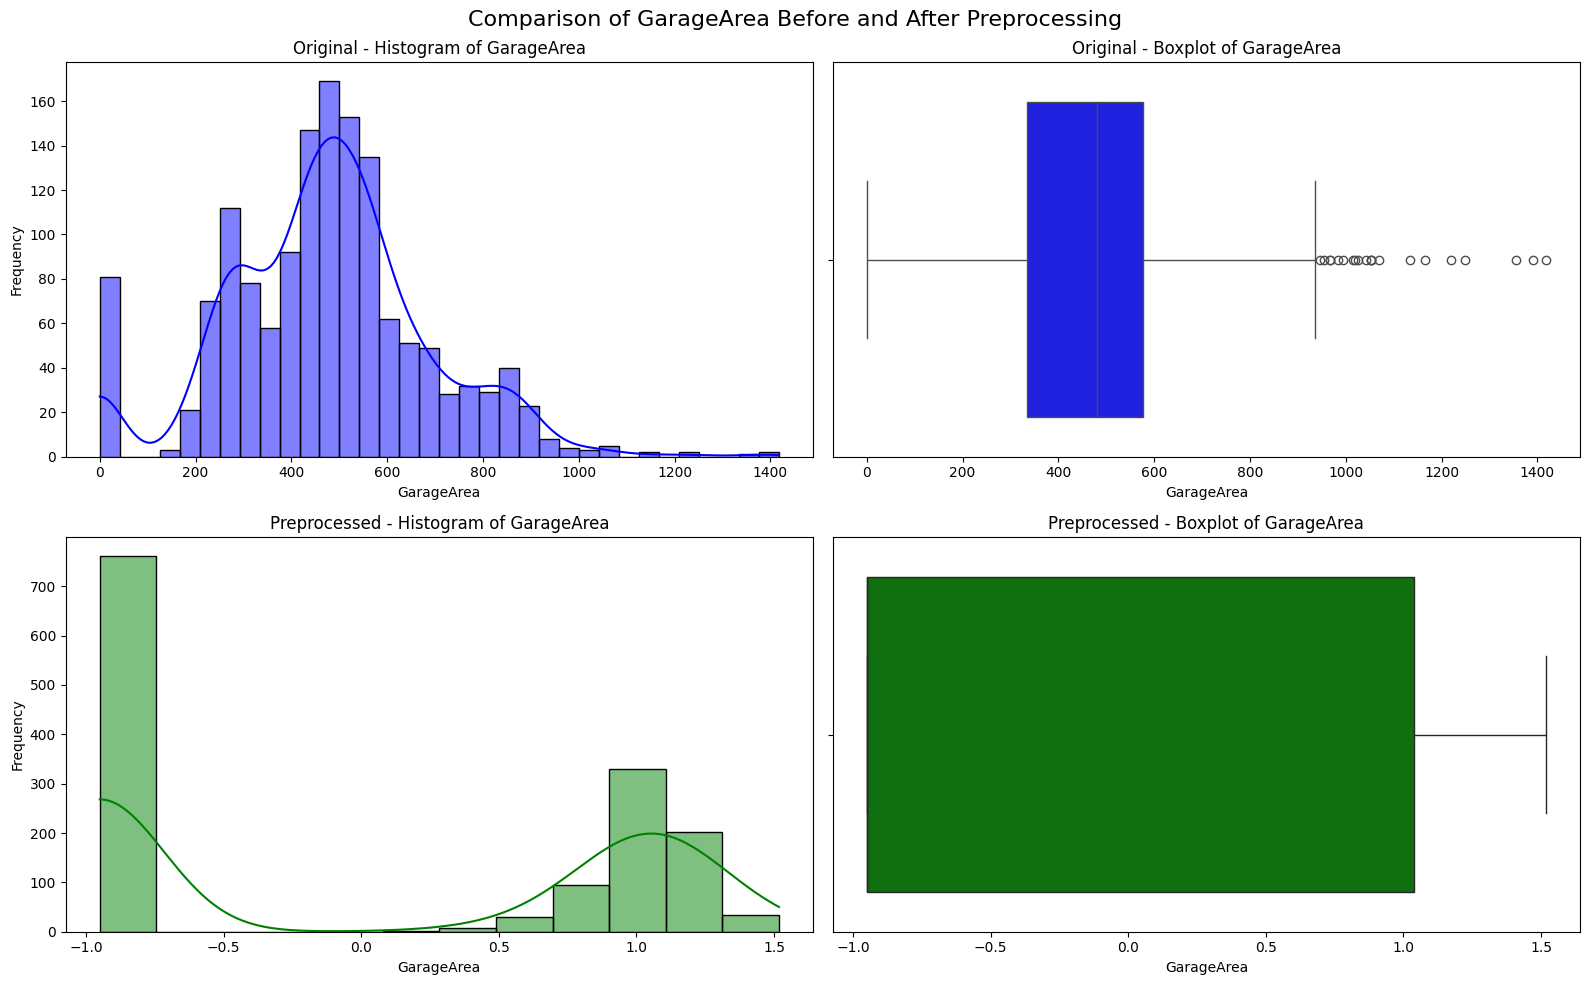

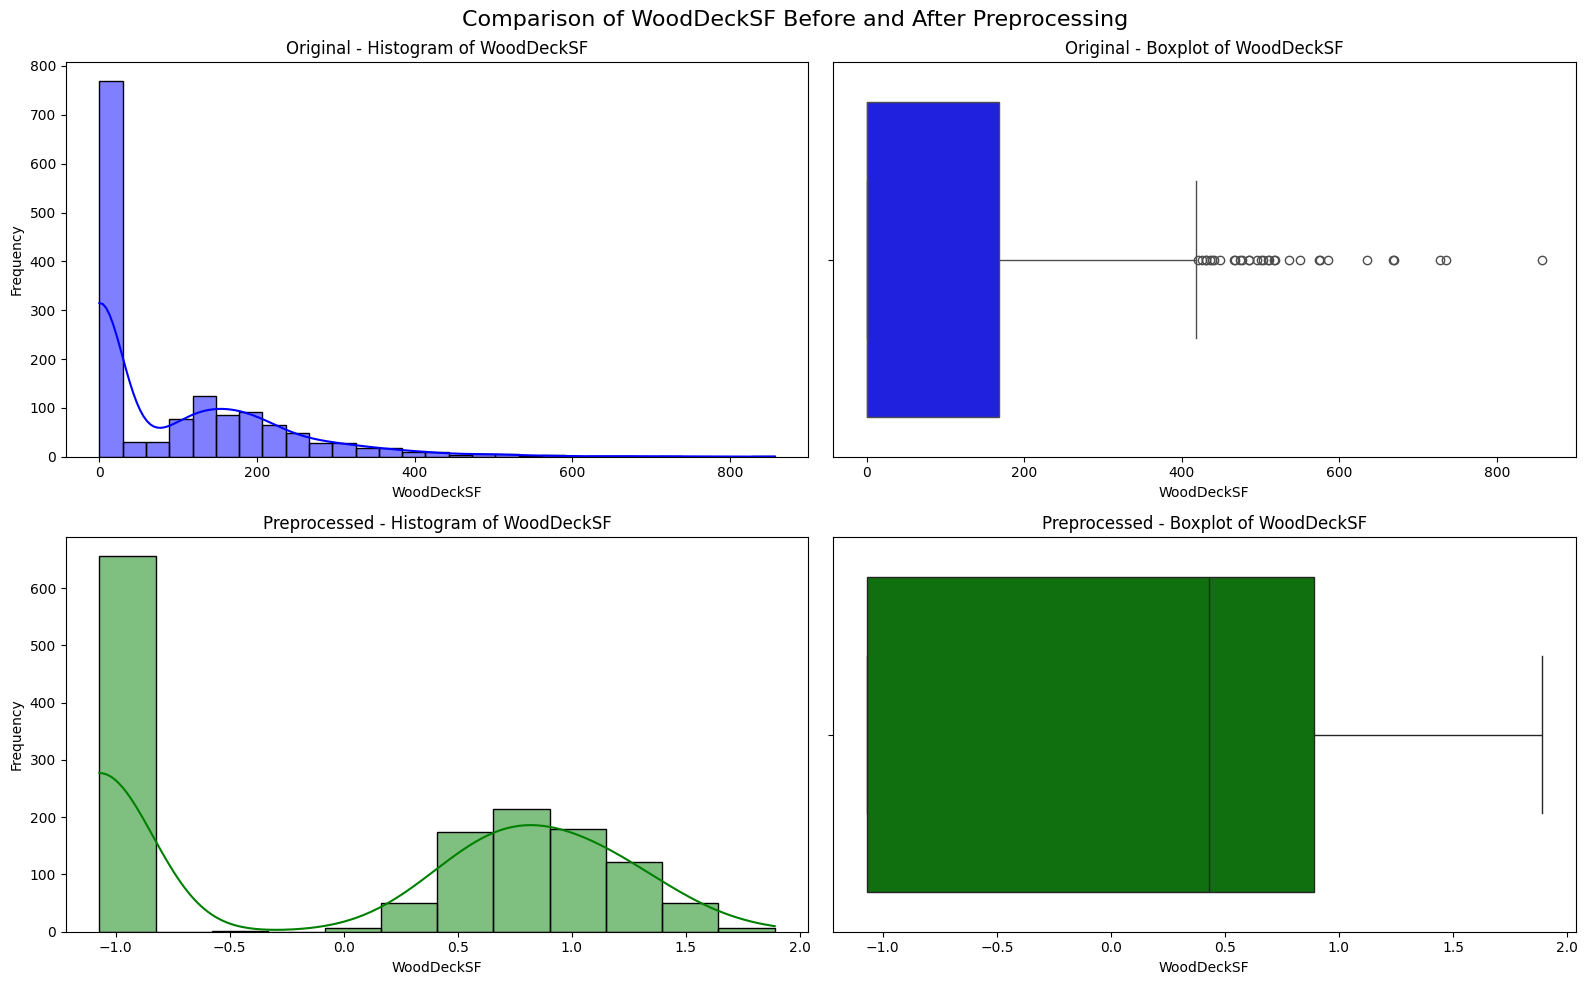

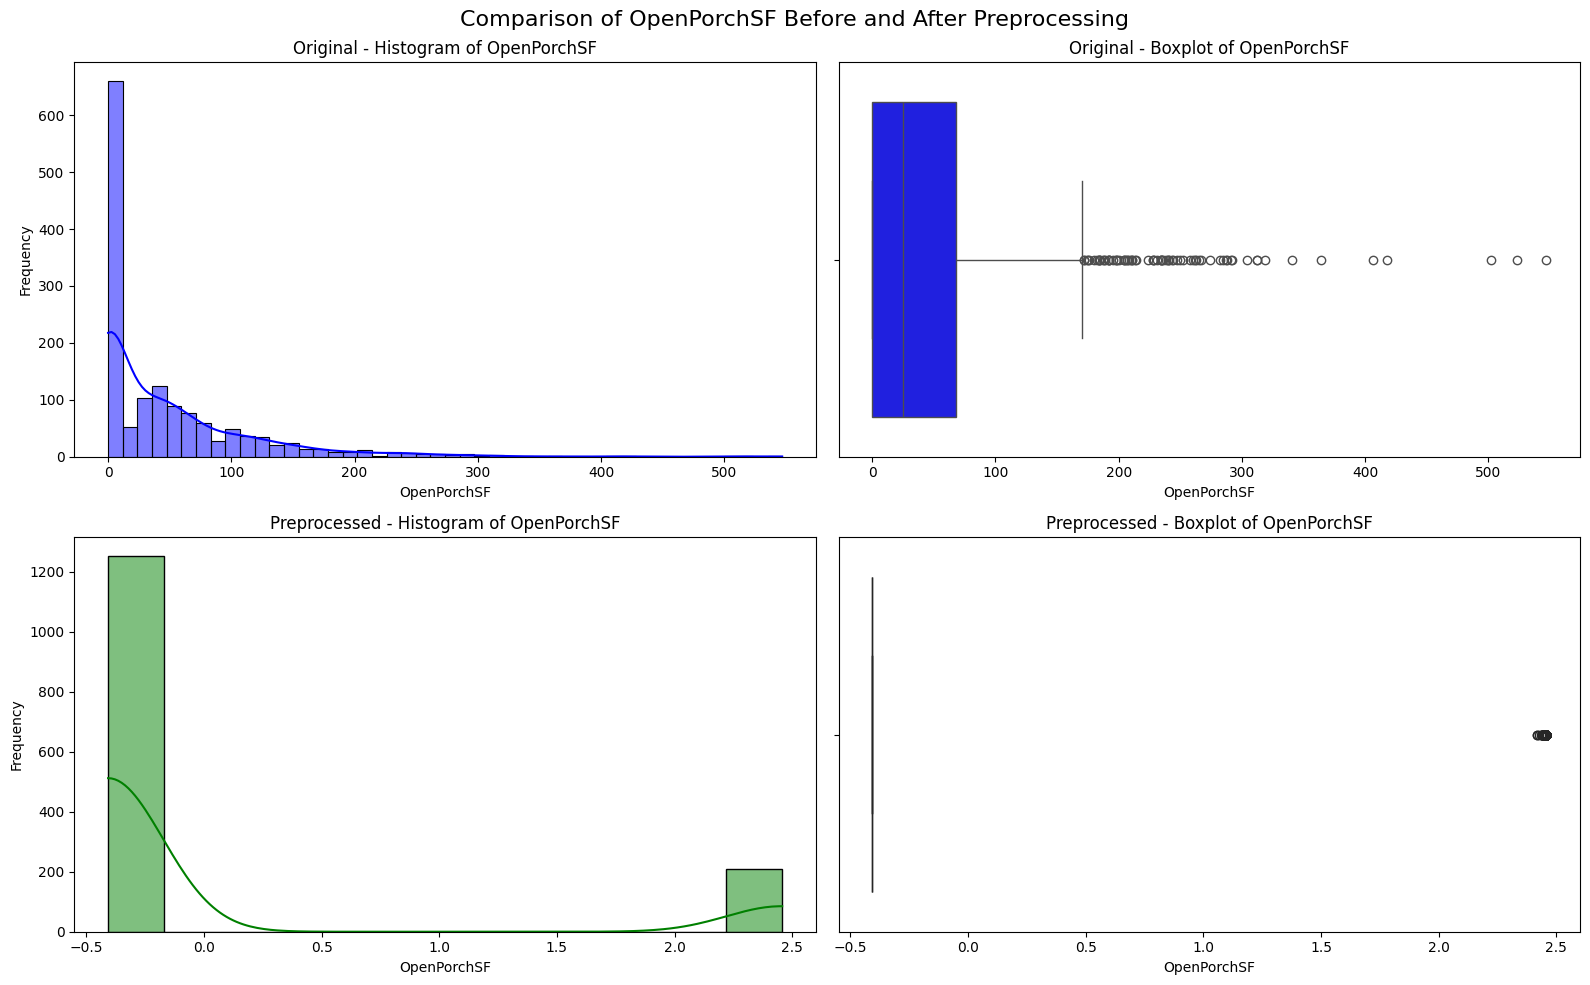

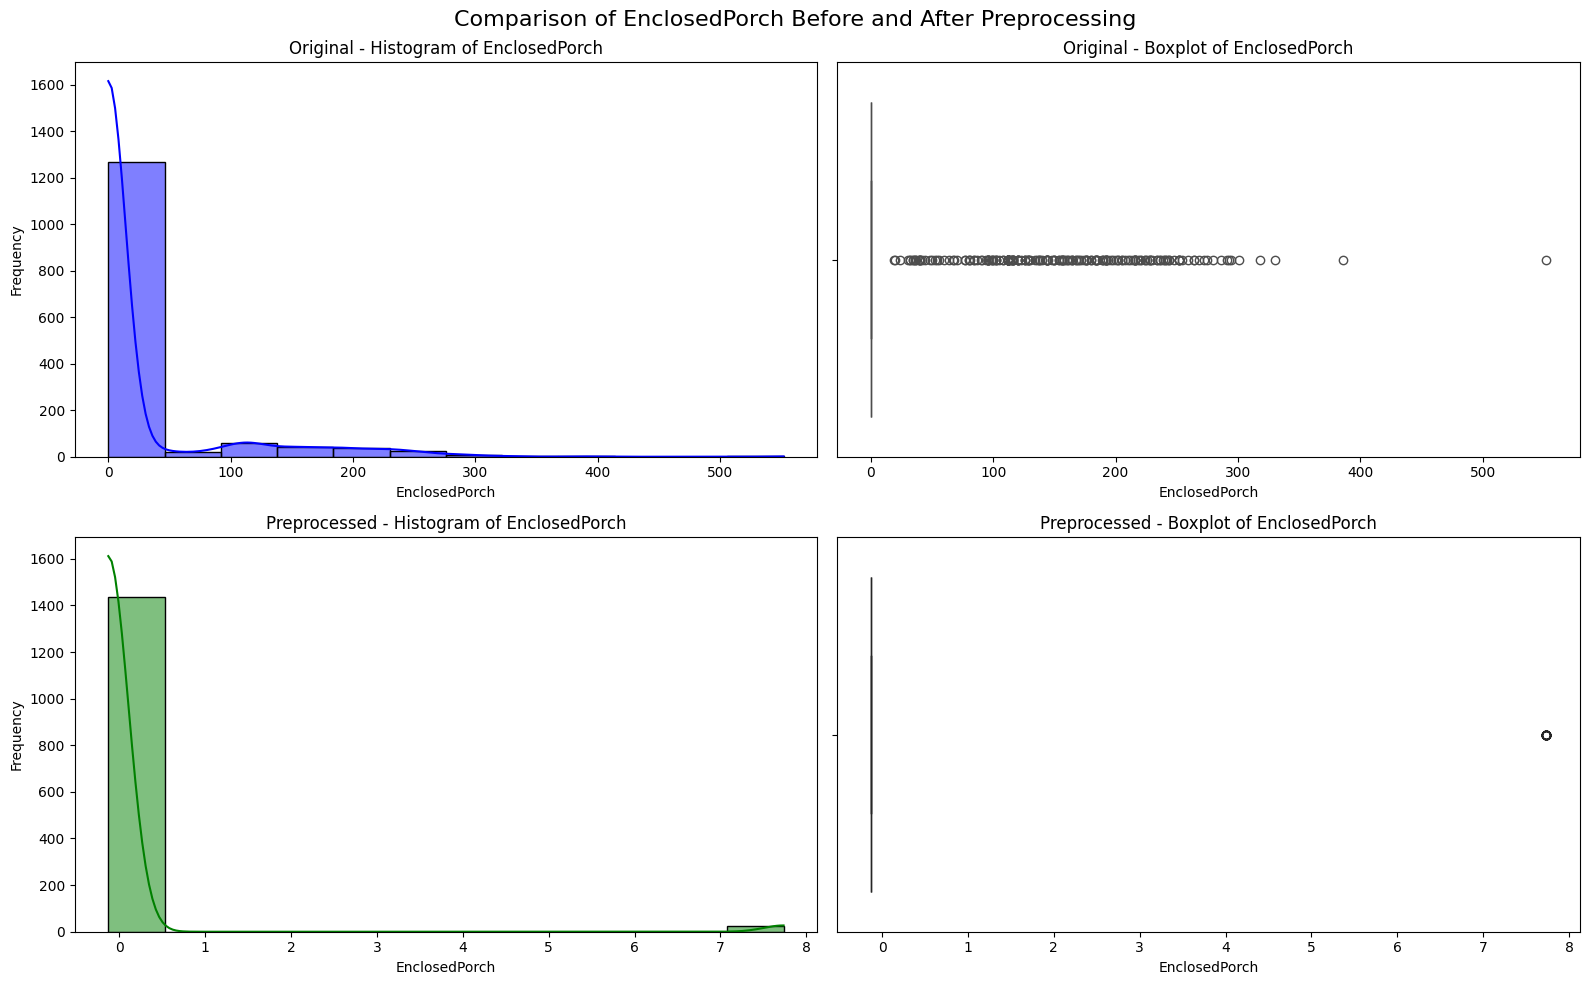

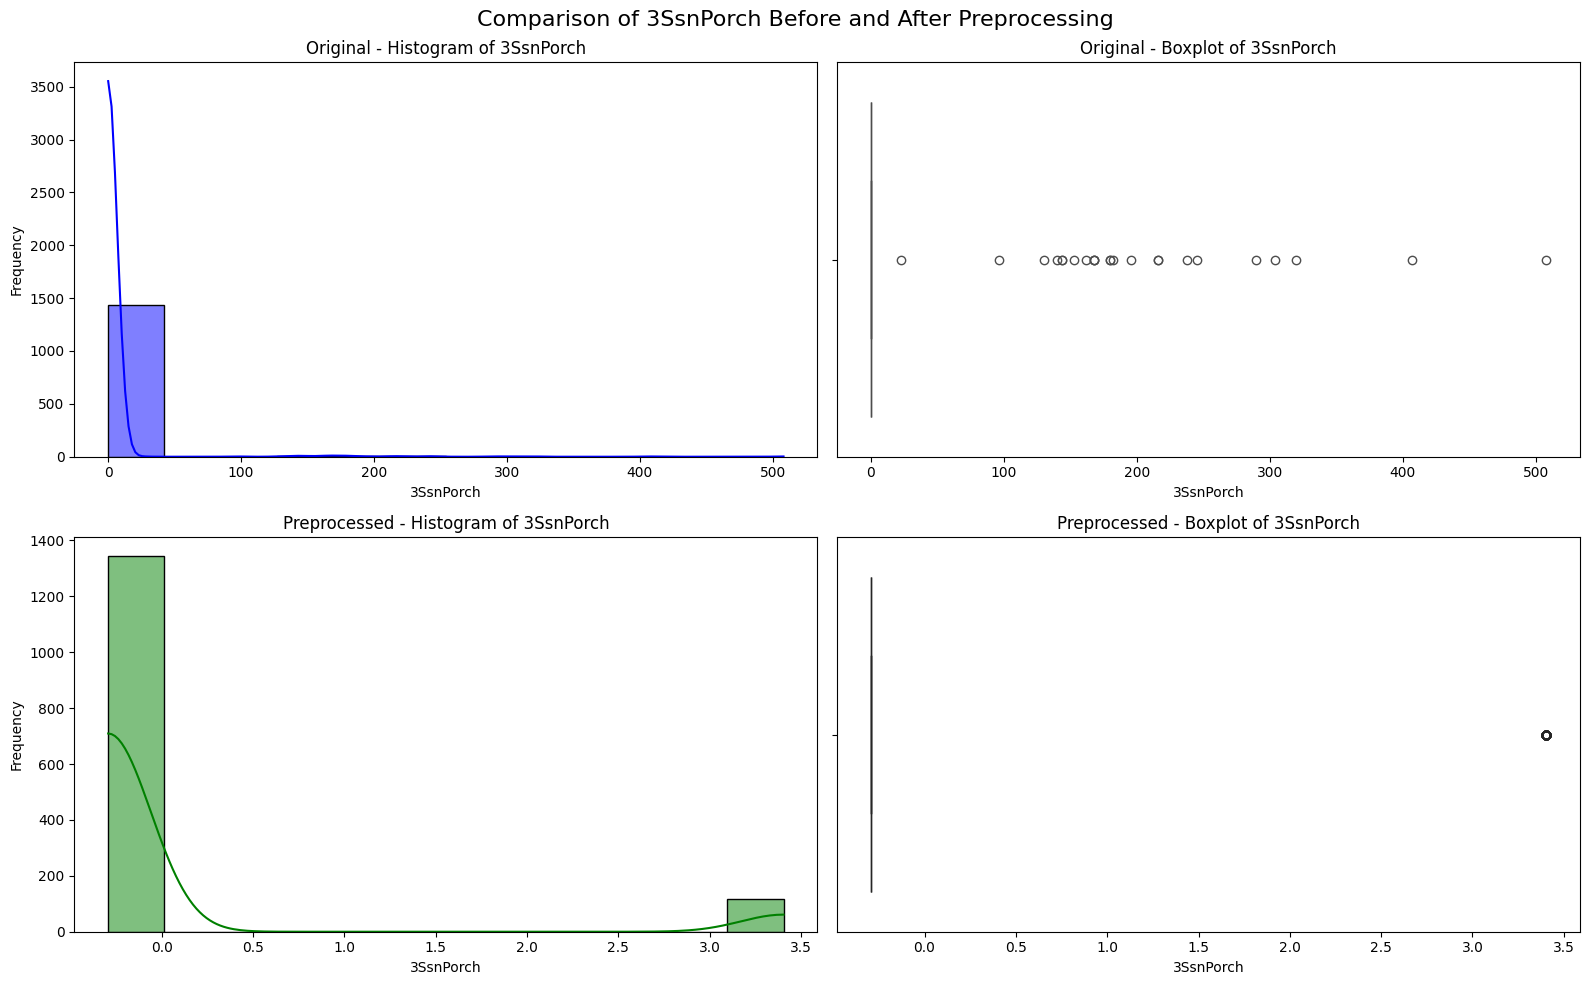

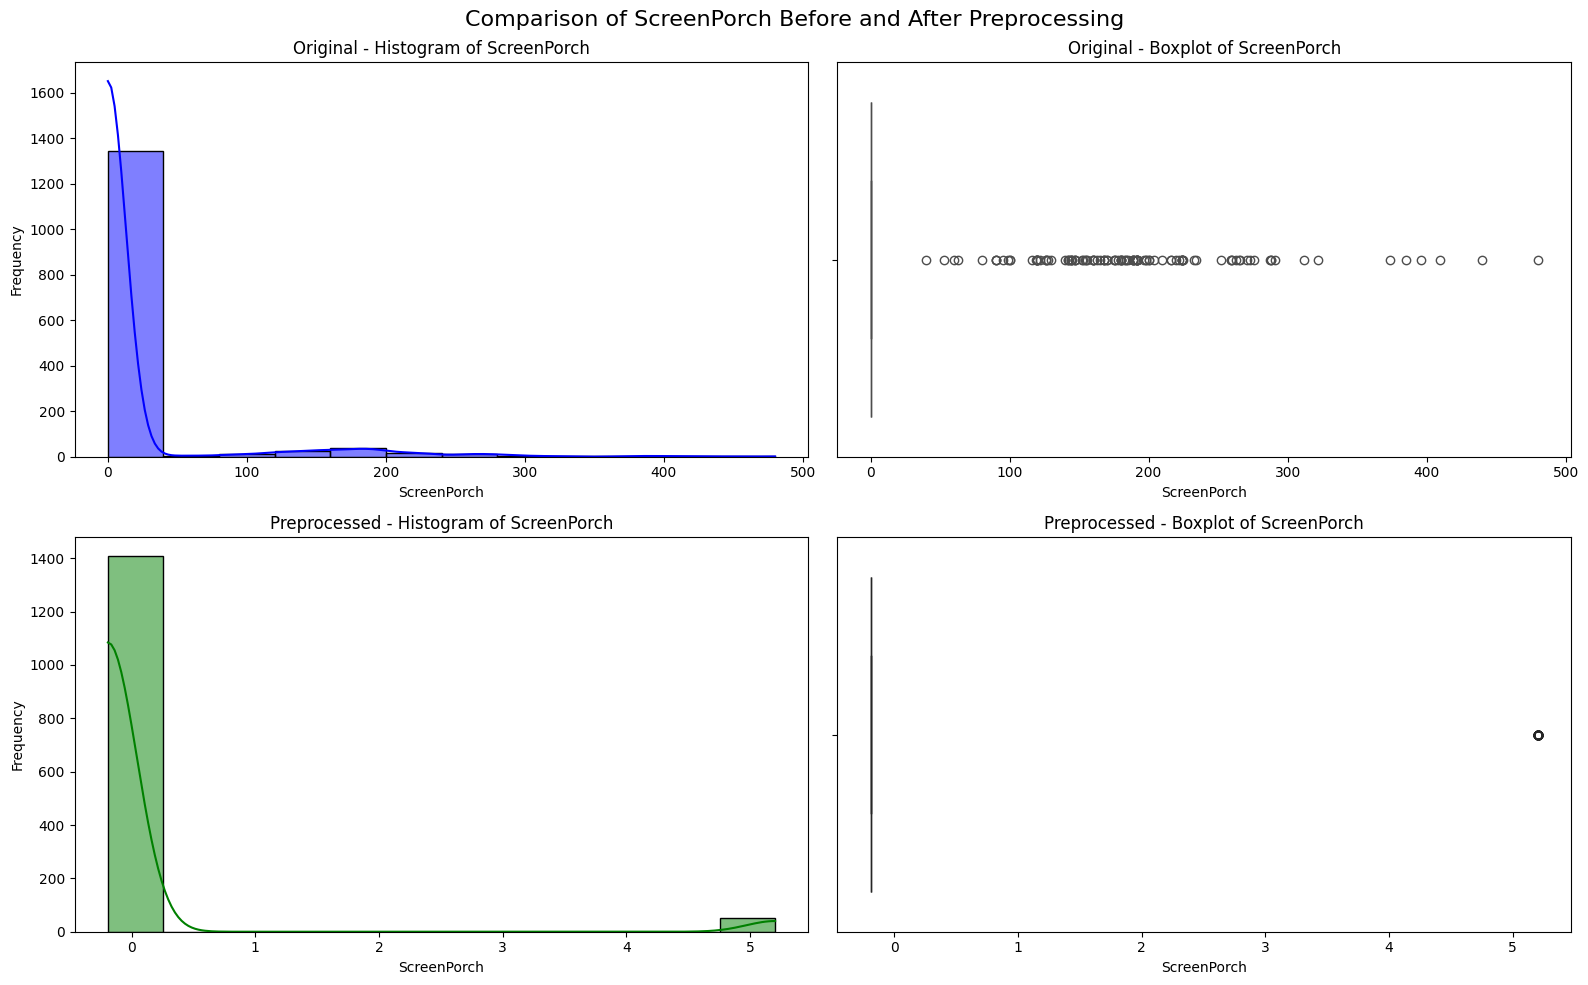

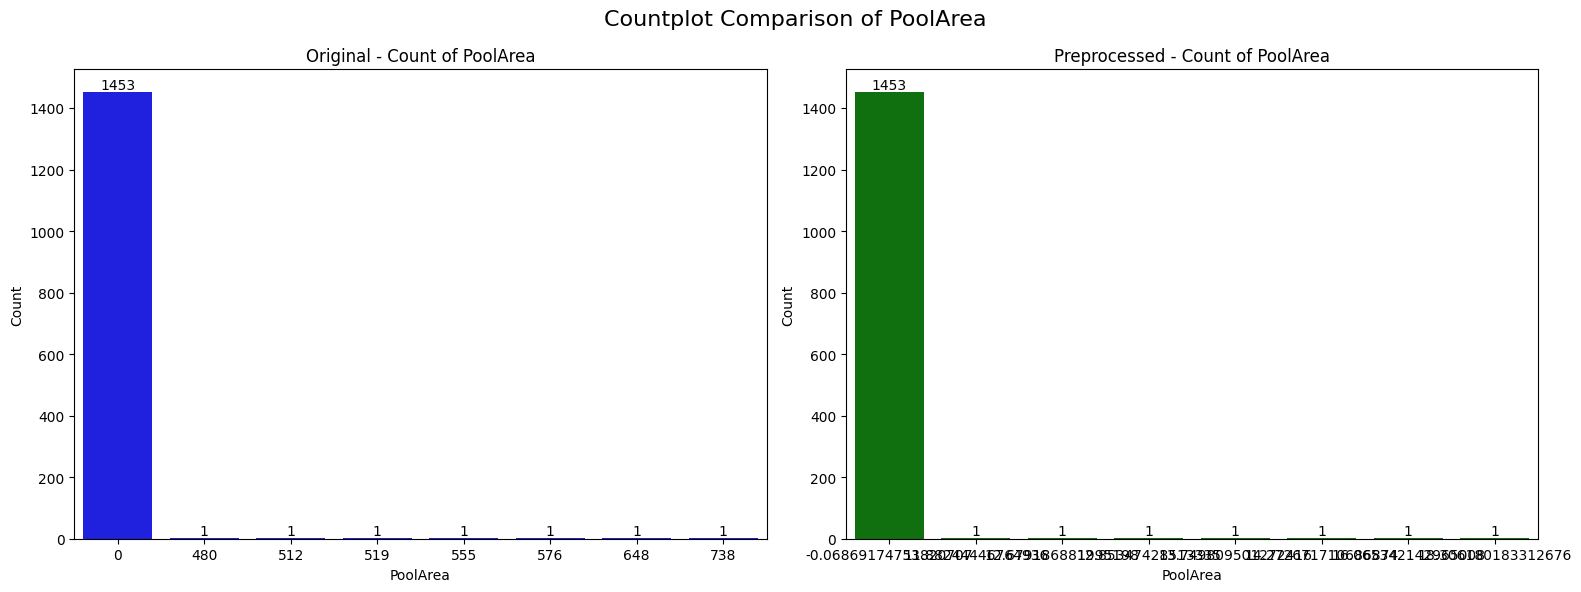

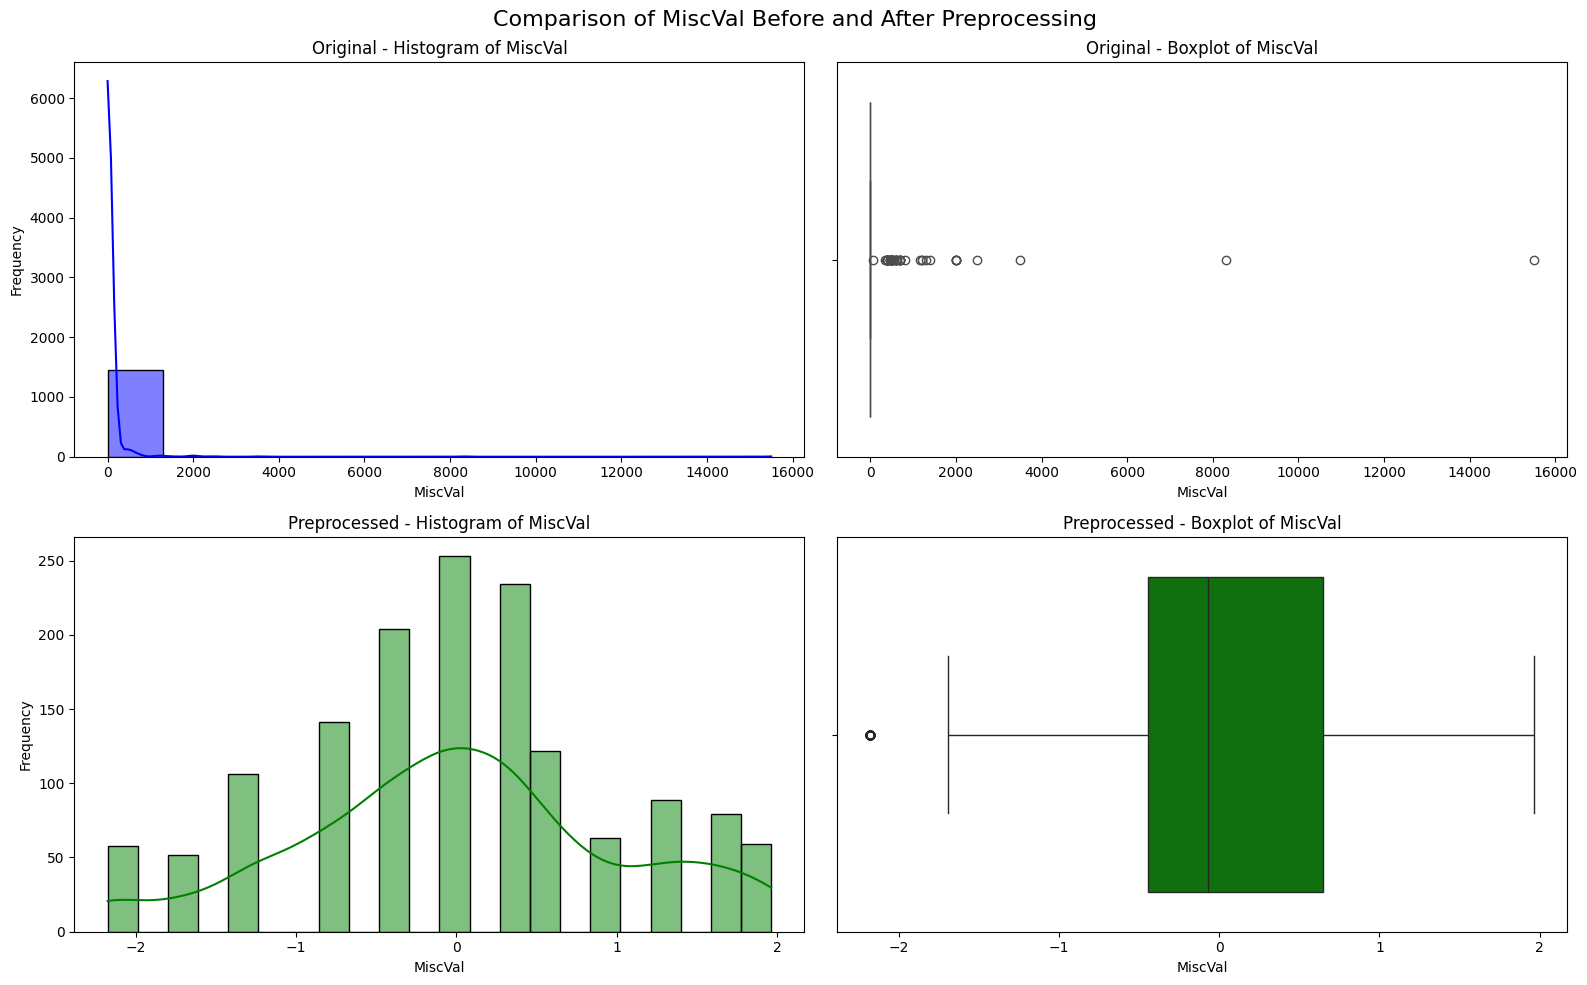

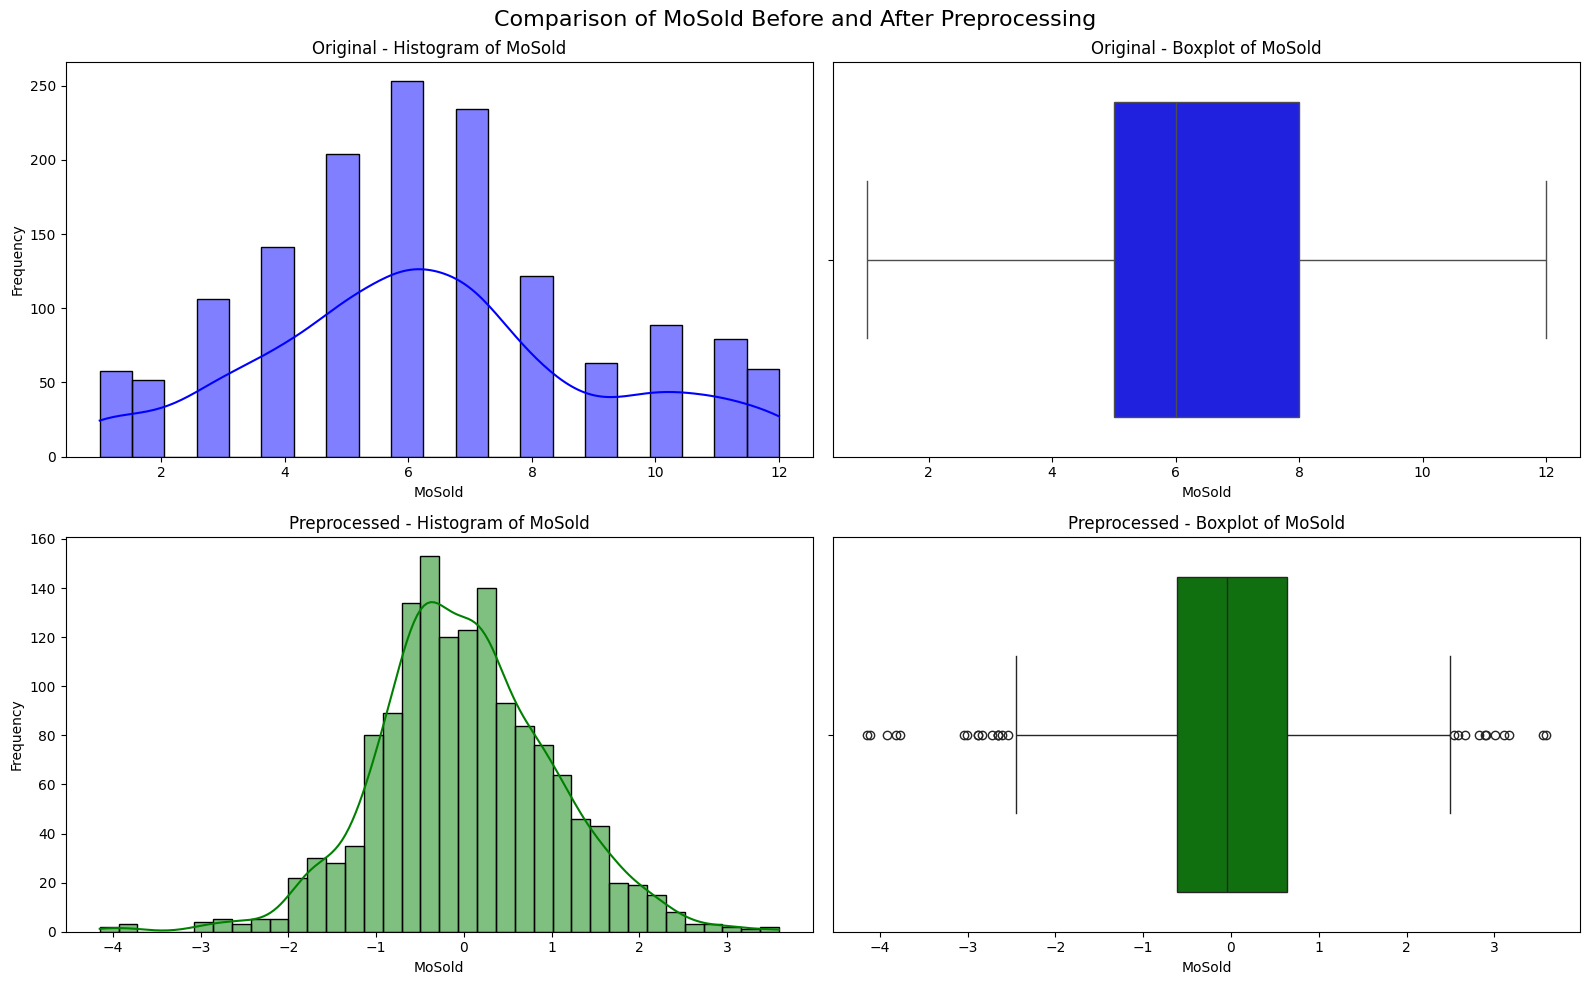

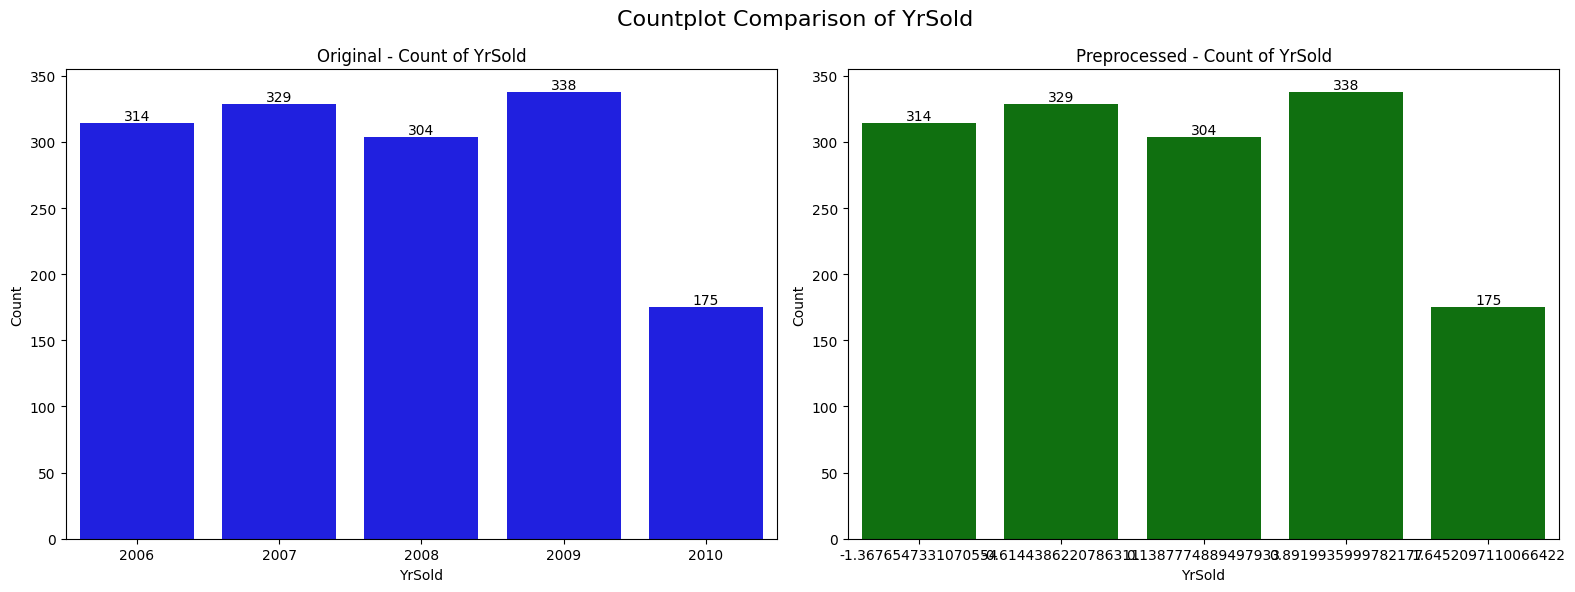

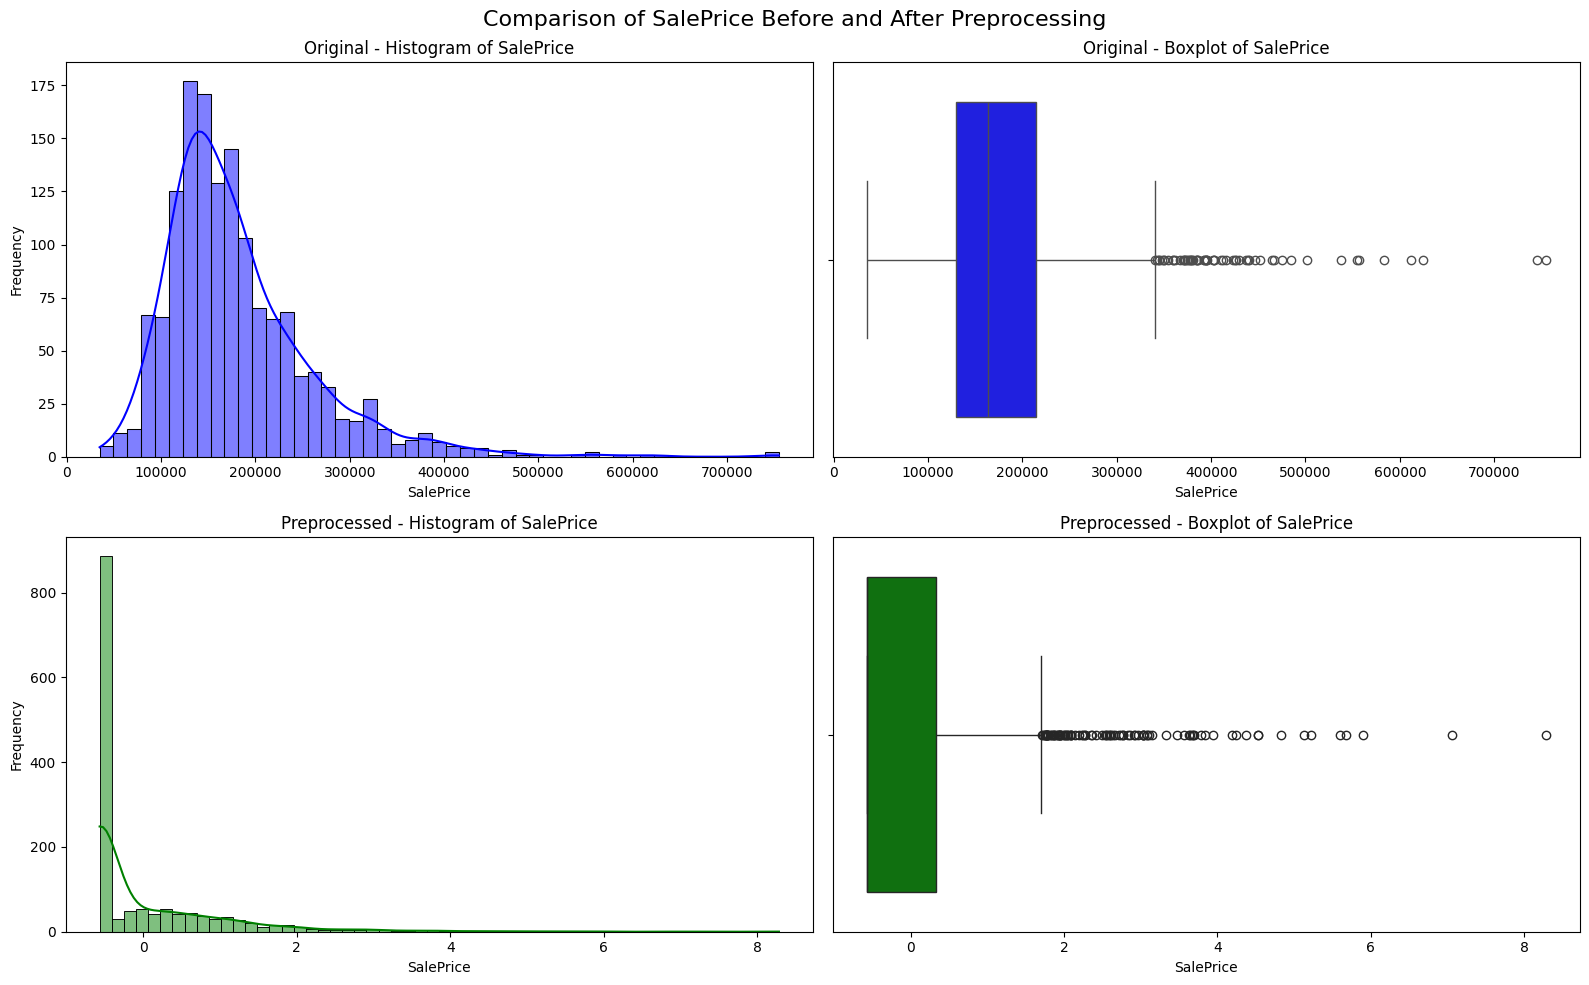

In [180]:
compare_univariate_analysis(df_original=X, df_preprocessed=X_preprocessed_df)

1. Why is GarageYrBlt distribution became like that??? very weird.  
2. Also why isnt there new columns created by the one hot encoder, and why is there very long decimal values in the categorical columns  
3. Also there are features that was bell shaped and not skewed that becamse skewed like garage area(might be because of the imputing that i did)

## These are features that had bad distributions
yearremodeled, mssubclass, lotarea, masvnrarea, bsmtfinsf1, bsmtfinsf2, 2ndflrsfm lowqualfinsf, garageyrblt, garagearea, wooddecksf, openporchsf, enclosedporch, 3ssnporch, screenporch, saleprice  
#### And after taking a look at the feature importance and iv / woe, we can decide if we want to dig in, on why each one of them have bad distribution

# EDA 2  

1. Correlation analysis
2. IV / WOE analysis
3. Feature importance using models